# Getting started with Word2Vec in Gensim and making it work!

The idea behind Word2Vec is pretty simple. We are making and assumption that you can tell the meaning of a word by the company it keeps. This is analogous to the saying *show me your friends, and I'll tell who you are*. So if you have two words that have very similar neighbors (i.e. the usage context is about the same), then these words are probably quite similar in meaning or are at least highly related. For example, the words `shocked`,`appalled` and `astonished` are typically used in a similar context. 

In this tutorial, you will learn how to use the Gensim implementation of Word2Vec and actually get it to work! I have heard a lot of complaints about poor performance etc, but its really a combination of two things, (1) your input data and (2) your parameter settings. Note that the training algorithms in this package were ported from the [original Word2Vec implementation by Google](https://arxiv.org/pdf/1301.3781.pdf) and extended with additional functionality.

### Imports and logging

First, we start with our imports and get logging established:

In [2]:
# imports needed and set up logging
import gzip
import gensim 
import logging
import glob, os
import math
import numpy as np

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


### Dataset 
Next, is our dataset. The secret to getting Word2Vec really working for you is to have lots and lots of text data. In this case I am going to use data from the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset. This dataset has full user reviews of cars and hotels. I have specifically concatenated all of the hotel reviews into one big file which is about 97MB compressed and 229MB uncompressed. We will use the compressed file for this tutorial. Each line in this file represents a hotel review. You can download the OpinRank Word2Vec dataset here.

To avoid confusion, while gensim’s word2vec tutorial says that you need to pass it a sequence of sentences as its input, you can always pass it a whole review as a sentence (i.e. a much larger size of text), and it should not make much of a difference. 

Now, let's take a closer look at this data below by printing the first line. You can see that this is a pretty hefty review.

In [3]:
import os,sys
sys.path.insert(0,"/home/msykulski/workspace/genXone/hackyeah2019/jupyter_init_workspace/src/")

import multiprocmap
from multiprocmap import parmap

In [136]:
data_file2=["/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/d**/*",
            "/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/c**/*",]
            #"/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/1**/*",
            #"/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/2**/*",]
            #"/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/3**/*",]

### Read files into a list
Now that we've had a sneak peak of our dataset, we can read it into a list so that we can pass this on to the Word2Vec model. Notice in the code below, that I am directly reading the 
compressed file. I'm also doing a mild pre-processing of the reviews using `gensim.utils.simple_preprocess (line)`. This does some basic pre-processing such as tokenization, lowercasing, etc and returns back a list of tokens (words). Documentation of this pre-processing method can be found on the official [Gensim documentation site](https://radimrehurek.com/gensim/utils.html). 



In [137]:
%%time 

#filenames=[]

def read_input(input_file_list):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file_list))
    files=[file for input_file in input_file_list for file in glob.glob(input_file)]
    def line_generator(file):
        with open(file, 'rb') as f:
            #filenames.append(file)
            for i, line in enumerate (f): 
            #if (i%10000==0):
                #logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
                yield gensim.utils.simple_preprocess (line)
            yield ["GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF","GXO_EOF"]
    all_lines=lambda file:(file,[l for l in line_generator(file)])
    #all_f_l=parmap(all_lines)
    return parmap(all_lines,files)
    

# read the tokenized reviews into a list
# each review item becomes a serries of words
# so this becomes a list of lists
#documents2 = list (read_input(data_file2))
all_f_l = read_input(data_file2)

documents2_org = [f_l[1] for f_l in all_f_l]
filenames_org = [f_l[0] for f_l in all_f_l]

logging.info ("Done reading data file")    

2019-09-15 13:30:40,867 : INFO : reading file ['/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/d**/*', '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/c**/*']...this may take a while
2019-09-15 13:32:28,937 : INFO : Done reading data file


CPU times: user 42.6 s, sys: 1min, total: 1min 43s
Wall time: 1min 48s


In [138]:
print(len(filenames_org))
documents2=[g for l in documents2_org for g in l]

358872


## Training the Word2Vec model

Training the model is fairly straightforward. You just instantiate Word2Vec and pass the reviews that we read in the previous step (the `documents`). So, we are essentially passing on a list of lists. Where each list within the main list contains a set of tokens from a user review. Word2Vec uses all these tokens to internally create a vocabulary. And by vocabulary, I mean a set of unique words.

After building the vocabulary, we just need to call `train(...)` to start training the Word2Vec model. Training on the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset takes about 10 minutes so please be patient while running your code on this dataset.

Behind the scenes we are actually training a simple neural network with a single hidden layer. But, we are actually not going to use the neural network after training. Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn. 

In [139]:
%%time
model = gensim.models.Word2Vec (documents2, size=150, window=10, min_count=1, workers=188)
model.train(documents2,total_examples=len(documents2),epochs=10)

2019-09-15 13:32:49,161 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-09-15 13:32:49,162 : INFO : collecting all words and their counts
2019-09-15 13:32:49,162 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-09-15 13:32:49,172 : INFO : PROGRESS: at sentence #10000, processed 24260 words, keeping 8732 word types
2019-09-15 13:32:49,185 : INFO : PROGRESS: at sentence #20000, processed 62967 words, keeping 18147 word types
2019-09-15 13:32:49,197 : INFO : PROGRESS: at sentence #30000, processed 101343 words, keeping 23541 word types
2019-09-15 13:32:49,209 : INFO : PROGRESS: at sentence #40000, processed 144043 words, keeping 28060 word types
2019-09-15 13:32:49,219 : INFO : PROGRESS: at sentence #50000, processed 178163 words, keeping 32077 word types
2019-09-15 13:32:49,229 : INFO : PROGRESS: at sentence #60000, processed 211130 words, keeping 36011 word types
2019-09-15 13:32:49,239 : INFO : PROGRESS: at sentence

2019-09-15 13:32:49,849 : INFO : PROGRESS: at sentence #710000, processed 2644479 words, keeping 216171 word types
2019-09-15 13:32:49,860 : INFO : PROGRESS: at sentence #720000, processed 2680744 words, keeping 218677 word types
2019-09-15 13:32:49,871 : INFO : PROGRESS: at sentence #730000, processed 2722671 words, keeping 221995 word types
2019-09-15 13:32:49,880 : INFO : PROGRESS: at sentence #740000, processed 2756929 words, keeping 224188 word types
2019-09-15 13:32:49,891 : INFO : PROGRESS: at sentence #750000, processed 2795150 words, keeping 226214 word types
2019-09-15 13:32:49,899 : INFO : PROGRESS: at sentence #760000, processed 2826611 words, keeping 227421 word types
2019-09-15 13:32:49,909 : INFO : PROGRESS: at sentence #770000, processed 2863181 words, keeping 229188 word types
2019-09-15 13:32:49,918 : INFO : PROGRESS: at sentence #780000, processed 2897461 words, keeping 230607 word types
2019-09-15 13:32:49,929 : INFO : PROGRESS: at sentence #790000, processed 293519

2019-09-15 13:32:50,555 : INFO : PROGRESS: at sentence #1420000, processed 5238664 words, keeping 398173 word types
2019-09-15 13:32:50,565 : INFO : PROGRESS: at sentence #1430000, processed 5274496 words, keeping 400027 word types
2019-09-15 13:32:50,573 : INFO : PROGRESS: at sentence #1440000, processed 5305385 words, keeping 401829 word types
2019-09-15 13:32:50,583 : INFO : PROGRESS: at sentence #1450000, processed 5344581 words, keeping 403214 word types
2019-09-15 13:32:50,592 : INFO : PROGRESS: at sentence #1460000, processed 5382197 words, keeping 404604 word types
2019-09-15 13:32:50,601 : INFO : PROGRESS: at sentence #1470000, processed 5416023 words, keeping 406167 word types
2019-09-15 13:32:50,611 : INFO : PROGRESS: at sentence #1480000, processed 5451362 words, keeping 407823 word types
2019-09-15 13:32:50,619 : INFO : PROGRESS: at sentence #1490000, processed 5486673 words, keeping 408944 word types
2019-09-15 13:32:50,629 : INFO : PROGRESS: at sentence #1500000, process

2019-09-15 13:32:51,240 : INFO : PROGRESS: at sentence #2130000, processed 7860160 words, keeping 533193 word types
2019-09-15 13:32:51,251 : INFO : PROGRESS: at sentence #2140000, processed 7898657 words, keeping 535719 word types
2019-09-15 13:32:51,266 : INFO : PROGRESS: at sentence #2150000, processed 7947697 words, keeping 548780 word types
2019-09-15 13:32:51,276 : INFO : PROGRESS: at sentence #2160000, processed 7981874 words, keeping 551970 word types
2019-09-15 13:32:51,288 : INFO : PROGRESS: at sentence #2170000, processed 8025266 words, keeping 556586 word types
2019-09-15 13:32:51,297 : INFO : PROGRESS: at sentence #2180000, processed 8058406 words, keeping 557833 word types
2019-09-15 13:32:51,308 : INFO : PROGRESS: at sentence #2190000, processed 8097992 words, keeping 560237 word types
2019-09-15 13:32:51,318 : INFO : PROGRESS: at sentence #2200000, processed 8137281 words, keeping 561539 word types
2019-09-15 13:32:51,328 : INFO : PROGRESS: at sentence #2210000, process

2019-09-15 13:32:52,005 : INFO : PROGRESS: at sentence #2840000, processed 10556781 words, keeping 663403 word types
2019-09-15 13:32:52,017 : INFO : PROGRESS: at sentence #2850000, processed 10593577 words, keeping 666303 word types
2019-09-15 13:32:52,028 : INFO : PROGRESS: at sentence #2860000, processed 10632050 words, keeping 667659 word types
2019-09-15 13:32:52,038 : INFO : PROGRESS: at sentence #2870000, processed 10671347 words, keeping 668655 word types
2019-09-15 13:32:52,048 : INFO : PROGRESS: at sentence #2880000, processed 10704513 words, keeping 669606 word types
2019-09-15 13:32:52,059 : INFO : PROGRESS: at sentence #2890000, processed 10738857 words, keeping 670819 word types
2019-09-15 13:32:52,071 : INFO : PROGRESS: at sentence #2900000, processed 10781574 words, keeping 672037 word types
2019-09-15 13:32:52,081 : INFO : PROGRESS: at sentence #2910000, processed 10818567 words, keeping 673465 word types
2019-09-15 13:32:52,092 : INFO : PROGRESS: at sentence #2920000,

2019-09-15 13:32:52,805 : INFO : PROGRESS: at sentence #3550000, processed 13212761 words, keeping 780531 word types
2019-09-15 13:32:52,815 : INFO : PROGRESS: at sentence #3560000, processed 13251422 words, keeping 781490 word types
2019-09-15 13:32:52,826 : INFO : PROGRESS: at sentence #3570000, processed 13287507 words, keeping 782821 word types
2019-09-15 13:32:52,839 : INFO : PROGRESS: at sentence #3580000, processed 13335885 words, keeping 784022 word types
2019-09-15 13:32:52,849 : INFO : PROGRESS: at sentence #3590000, processed 13363987 words, keeping 789908 word types
2019-09-15 13:32:52,860 : INFO : PROGRESS: at sentence #3600000, processed 13400385 words, keeping 791101 word types
2019-09-15 13:32:52,871 : INFO : PROGRESS: at sentence #3610000, processed 13444148 words, keeping 792134 word types
2019-09-15 13:32:52,883 : INFO : PROGRESS: at sentence #3620000, processed 13481217 words, keeping 793737 word types
2019-09-15 13:32:52,892 : INFO : PROGRESS: at sentence #3630000,

2019-09-15 13:32:53,572 : INFO : PROGRESS: at sentence #4260000, processed 15687052 words, keeping 907136 word types
2019-09-15 13:32:53,584 : INFO : PROGRESS: at sentence #4270000, processed 15729533 words, keeping 908277 word types
2019-09-15 13:32:53,596 : INFO : PROGRESS: at sentence #4280000, processed 15773417 words, keeping 909689 word types
2019-09-15 13:32:53,605 : INFO : PROGRESS: at sentence #4290000, processed 15802513 words, keeping 910340 word types
2019-09-15 13:32:53,615 : INFO : PROGRESS: at sentence #4300000, processed 15834653 words, keeping 911417 word types
2019-09-15 13:32:53,625 : INFO : PROGRESS: at sentence #4310000, processed 15871848 words, keeping 912577 word types
2019-09-15 13:32:53,636 : INFO : PROGRESS: at sentence #4320000, processed 15907108 words, keeping 913498 word types
2019-09-15 13:32:53,645 : INFO : PROGRESS: at sentence #4330000, processed 15939569 words, keeping 914440 word types
2019-09-15 13:32:53,655 : INFO : PROGRESS: at sentence #4340000,

2019-09-15 13:32:54,345 : INFO : PROGRESS: at sentence #4960000, processed 18307969 words, keeping 1027602 word types
2019-09-15 13:32:54,356 : INFO : PROGRESS: at sentence #4970000, processed 18349892 words, keeping 1028836 word types
2019-09-15 13:32:54,365 : INFO : PROGRESS: at sentence #4980000, processed 18383914 words, keeping 1030149 word types
2019-09-15 13:32:54,376 : INFO : PROGRESS: at sentence #4990000, processed 18428836 words, keeping 1031555 word types
2019-09-15 13:32:54,386 : INFO : PROGRESS: at sentence #5000000, processed 18465465 words, keeping 1032511 word types
2019-09-15 13:32:54,396 : INFO : PROGRESS: at sentence #5010000, processed 18500674 words, keeping 1033390 word types
2019-09-15 13:32:54,406 : INFO : PROGRESS: at sentence #5020000, processed 18539423 words, keeping 1034574 word types
2019-09-15 13:32:54,417 : INFO : PROGRESS: at sentence #5030000, processed 18579604 words, keeping 1036307 word types
2019-09-15 13:32:54,428 : INFO : PROGRESS: at sentence #

2019-09-15 13:32:55,063 : INFO : PROGRESS: at sentence #5660000, processed 20851326 words, keeping 1150230 word types
2019-09-15 13:32:55,072 : INFO : PROGRESS: at sentence #5670000, processed 20884242 words, keeping 1151099 word types
2019-09-15 13:32:55,081 : INFO : PROGRESS: at sentence #5680000, processed 20916572 words, keeping 1152020 word types
2019-09-15 13:32:55,091 : INFO : PROGRESS: at sentence #5690000, processed 20960228 words, keeping 1153154 word types
2019-09-15 13:32:55,102 : INFO : PROGRESS: at sentence #5700000, processed 20994096 words, keeping 1156894 word types
2019-09-15 13:32:55,112 : INFO : PROGRESS: at sentence #5710000, processed 21033153 words, keeping 1157842 word types
2019-09-15 13:32:55,122 : INFO : PROGRESS: at sentence #5720000, processed 21072303 words, keeping 1158855 word types
2019-09-15 13:32:55,131 : INFO : PROGRESS: at sentence #5730000, processed 21106897 words, keeping 1159907 word types
2019-09-15 13:32:55,141 : INFO : PROGRESS: at sentence #

2019-09-15 13:32:55,759 : INFO : PROGRESS: at sentence #6360000, processed 23490055 words, keeping 1247065 word types
2019-09-15 13:32:55,769 : INFO : PROGRESS: at sentence #6370000, processed 23526398 words, keeping 1247928 word types
2019-09-15 13:32:55,779 : INFO : PROGRESS: at sentence #6380000, processed 23564366 words, keeping 1249603 word types
2019-09-15 13:32:55,788 : INFO : PROGRESS: at sentence #6390000, processed 23598945 words, keeping 1250962 word types
2019-09-15 13:32:55,797 : INFO : PROGRESS: at sentence #6400000, processed 23630704 words, keeping 1251733 word types
2019-09-15 13:32:55,806 : INFO : PROGRESS: at sentence #6410000, processed 23665473 words, keeping 1252871 word types
2019-09-15 13:32:55,817 : INFO : PROGRESS: at sentence #6420000, processed 23706496 words, keeping 1254174 word types
2019-09-15 13:32:55,826 : INFO : PROGRESS: at sentence #6430000, processed 23737655 words, keeping 1255274 word types
2019-09-15 13:32:55,836 : INFO : PROGRESS: at sentence #

2019-09-15 13:32:56,454 : INFO : PROGRESS: at sentence #7060000, processed 26074256 words, keeping 1342943 word types
2019-09-15 13:32:56,464 : INFO : PROGRESS: at sentence #7070000, processed 26100322 words, keeping 1348401 word types
2019-09-15 13:32:56,475 : INFO : PROGRESS: at sentence #7080000, processed 26137923 words, keeping 1349797 word types
2019-09-15 13:32:56,485 : INFO : PROGRESS: at sentence #7090000, processed 26171223 words, keeping 1350558 word types
2019-09-15 13:32:56,496 : INFO : PROGRESS: at sentence #7100000, processed 26214504 words, keeping 1351558 word types
2019-09-15 13:32:56,506 : INFO : PROGRESS: at sentence #7110000, processed 26252570 words, keeping 1352600 word types
2019-09-15 13:32:56,516 : INFO : PROGRESS: at sentence #7120000, processed 26289612 words, keeping 1353265 word types
2019-09-15 13:32:56,526 : INFO : PROGRESS: at sentence #7130000, processed 26327964 words, keeping 1354189 word types
2019-09-15 13:32:56,536 : INFO : PROGRESS: at sentence #

2019-09-15 13:32:57,266 : INFO : PROGRESS: at sentence #7760000, processed 28623220 words, keeping 1471293 word types
2019-09-15 13:32:57,276 : INFO : PROGRESS: at sentence #7770000, processed 28658897 words, keeping 1472308 word types
2019-09-15 13:32:57,285 : INFO : PROGRESS: at sentence #7780000, processed 28698459 words, keeping 1473124 word types
2019-09-15 13:32:57,295 : INFO : PROGRESS: at sentence #7790000, processed 28734970 words, keeping 1473884 word types
2019-09-15 13:32:57,304 : INFO : PROGRESS: at sentence #7800000, processed 28770595 words, keeping 1474509 word types
2019-09-15 13:32:57,315 : INFO : PROGRESS: at sentence #7810000, processed 28804983 words, keeping 1477047 word types
2019-09-15 13:32:57,323 : INFO : PROGRESS: at sentence #7820000, processed 28829210 words, keeping 1482309 word types
2019-09-15 13:32:57,334 : INFO : PROGRESS: at sentence #7830000, processed 28874439 words, keeping 1483026 word types
2019-09-15 13:32:57,345 : INFO : PROGRESS: at sentence #

2019-09-15 13:32:57,981 : INFO : PROGRESS: at sentence #8460000, processed 31225109 words, keeping 1583844 word types
2019-09-15 13:32:57,992 : INFO : PROGRESS: at sentence #8470000, processed 31261793 words, keeping 1585141 word types
2019-09-15 13:32:58,002 : INFO : PROGRESS: at sentence #8480000, processed 31300255 words, keeping 1586326 word types
2019-09-15 13:32:58,013 : INFO : PROGRESS: at sentence #8490000, processed 31339038 words, keeping 1587533 word types
2019-09-15 13:32:58,024 : INFO : PROGRESS: at sentence #8500000, processed 31381219 words, keeping 1588615 word types
2019-09-15 13:32:58,033 : INFO : PROGRESS: at sentence #8510000, processed 31415861 words, keeping 1589374 word types
2019-09-15 13:32:58,045 : INFO : PROGRESS: at sentence #8520000, processed 31461901 words, keeping 1590413 word types
2019-09-15 13:32:58,057 : INFO : PROGRESS: at sentence #8530000, processed 31502983 words, keeping 1591683 word types
2019-09-15 13:32:58,066 : INFO : PROGRESS: at sentence #

2019-09-15 13:32:58,710 : INFO : PROGRESS: at sentence #9160000, processed 33891034 words, keeping 1670276 word types
2019-09-15 13:32:58,719 : INFO : PROGRESS: at sentence #9170000, processed 33926852 words, keeping 1670885 word types
2019-09-15 13:32:58,729 : INFO : PROGRESS: at sentence #9180000, processed 33966602 words, keeping 1671639 word types
2019-09-15 13:32:58,739 : INFO : PROGRESS: at sentence #9190000, processed 34001755 words, keeping 1672442 word types
2019-09-15 13:32:58,750 : INFO : PROGRESS: at sentence #9200000, processed 34047274 words, keeping 1673576 word types
2019-09-15 13:32:58,760 : INFO : PROGRESS: at sentence #9210000, processed 34088436 words, keeping 1674562 word types
2019-09-15 13:32:58,770 : INFO : PROGRESS: at sentence #9220000, processed 34124119 words, keeping 1675820 word types
2019-09-15 13:32:58,780 : INFO : PROGRESS: at sentence #9230000, processed 34164334 words, keeping 1676504 word types
2019-09-15 13:32:58,790 : INFO : PROGRESS: at sentence #

2019-09-15 13:32:59,452 : INFO : PROGRESS: at sentence #9860000, processed 36513414 words, keeping 1767689 word types
2019-09-15 13:32:59,462 : INFO : PROGRESS: at sentence #9870000, processed 36553251 words, keeping 1768296 word types
2019-09-15 13:32:59,471 : INFO : PROGRESS: at sentence #9880000, processed 36589626 words, keeping 1768996 word types
2019-09-15 13:32:59,481 : INFO : PROGRESS: at sentence #9890000, processed 36630557 words, keeping 1769906 word types
2019-09-15 13:32:59,493 : INFO : PROGRESS: at sentence #9900000, processed 36666505 words, keeping 1771468 word types
2019-09-15 13:32:59,503 : INFO : PROGRESS: at sentence #9910000, processed 36710485 words, keeping 1772403 word types
2019-09-15 13:32:59,513 : INFO : PROGRESS: at sentence #9920000, processed 36750384 words, keeping 1773188 word types
2019-09-15 13:32:59,524 : INFO : PROGRESS: at sentence #9930000, processed 36789112 words, keeping 1774106 word types
2019-09-15 13:32:59,534 : INFO : PROGRESS: at sentence #

2019-09-15 13:33:00,168 : INFO : PROGRESS: at sentence #10550000, processed 39142918 words, keeping 1862801 word types
2019-09-15 13:33:00,178 : INFO : PROGRESS: at sentence #10560000, processed 39180270 words, keeping 1863878 word types
2019-09-15 13:33:00,187 : INFO : PROGRESS: at sentence #10570000, processed 39215005 words, keeping 1864718 word types
2019-09-15 13:33:00,196 : INFO : PROGRESS: at sentence #10580000, processed 39246296 words, keeping 1865452 word types
2019-09-15 13:33:00,206 : INFO : PROGRESS: at sentence #10590000, processed 39284864 words, keeping 1866065 word types
2019-09-15 13:33:00,216 : INFO : PROGRESS: at sentence #10600000, processed 39325507 words, keeping 1866741 word types
2019-09-15 13:33:00,226 : INFO : PROGRESS: at sentence #10610000, processed 39361590 words, keeping 1867500 word types
2019-09-15 13:33:00,234 : INFO : PROGRESS: at sentence #10620000, processed 39392834 words, keeping 1868285 word types
2019-09-15 13:33:00,244 : INFO : PROGRESS: at se

2019-09-15 13:33:00,874 : INFO : PROGRESS: at sentence #11240000, processed 41773858 words, keeping 1942217 word types
2019-09-15 13:33:00,884 : INFO : PROGRESS: at sentence #11250000, processed 41812259 words, keeping 1942969 word types
2019-09-15 13:33:00,894 : INFO : PROGRESS: at sentence #11260000, processed 41847056 words, keeping 1943993 word types
2019-09-15 13:33:00,904 : INFO : PROGRESS: at sentence #11270000, processed 41885794 words, keeping 1945846 word types
2019-09-15 13:33:00,914 : INFO : PROGRESS: at sentence #11280000, processed 41922825 words, keeping 1947035 word types
2019-09-15 13:33:00,924 : INFO : PROGRESS: at sentence #11290000, processed 41959109 words, keeping 1948399 word types
2019-09-15 13:33:00,935 : INFO : PROGRESS: at sentence #11300000, processed 42003322 words, keeping 1949725 word types
2019-09-15 13:33:00,944 : INFO : PROGRESS: at sentence #11310000, processed 42038200 words, keeping 1950395 word types
2019-09-15 13:33:00,955 : INFO : PROGRESS: at se

2019-09-15 13:33:01,579 : INFO : PROGRESS: at sentence #11930000, processed 44353016 words, keeping 2034808 word types
2019-09-15 13:33:01,589 : INFO : PROGRESS: at sentence #11940000, processed 44394950 words, keeping 2035620 word types
2019-09-15 13:33:01,599 : INFO : PROGRESS: at sentence #11950000, processed 44433604 words, keeping 2036595 word types
2019-09-15 13:33:01,610 : INFO : PROGRESS: at sentence #11960000, processed 44473233 words, keeping 2037363 word types
2019-09-15 13:33:01,621 : INFO : PROGRESS: at sentence #11970000, processed 44514749 words, keeping 2038641 word types
2019-09-15 13:33:01,638 : INFO : PROGRESS: at sentence #11980000, processed 44562250 words, keeping 2048151 word types
2019-09-15 13:33:01,649 : INFO : PROGRESS: at sentence #11990000, processed 44602106 words, keeping 2049201 word types
2019-09-15 13:33:01,659 : INFO : PROGRESS: at sentence #12000000, processed 44641596 words, keeping 2050050 word types
2019-09-15 13:33:01,670 : INFO : PROGRESS: at se

2019-09-15 13:33:02,294 : INFO : PROGRESS: at sentence #12620000, processed 46975615 words, keeping 2124757 word types
2019-09-15 13:33:02,302 : INFO : PROGRESS: at sentence #12630000, processed 47006898 words, keeping 2125302 word types
2019-09-15 13:33:02,311 : INFO : PROGRESS: at sentence #12640000, processed 47040071 words, keeping 2125915 word types
2019-09-15 13:33:02,322 : INFO : PROGRESS: at sentence #12650000, processed 47083473 words, keeping 2126803 word types
2019-09-15 13:33:02,333 : INFO : PROGRESS: at sentence #12660000, processed 47124323 words, keeping 2127986 word types
2019-09-15 13:33:02,345 : INFO : PROGRESS: at sentence #12670000, processed 47169069 words, keeping 2129113 word types
2019-09-15 13:33:02,354 : INFO : PROGRESS: at sentence #12680000, processed 47205151 words, keeping 2129837 word types
2019-09-15 13:33:02,365 : INFO : PROGRESS: at sentence #12690000, processed 47248504 words, keeping 2131042 word types
2019-09-15 13:33:02,376 : INFO : PROGRESS: at se

2019-09-15 13:33:02,991 : INFO : PROGRESS: at sentence #13310000, processed 49496633 words, keeping 2213370 word types
2019-09-15 13:33:03,001 : INFO : PROGRESS: at sentence #13320000, processed 49531135 words, keeping 2213974 word types
2019-09-15 13:33:03,012 : INFO : PROGRESS: at sentence #13330000, processed 49568804 words, keeping 2214734 word types
2019-09-15 13:33:03,022 : INFO : PROGRESS: at sentence #13340000, processed 49605407 words, keeping 2215439 word types
2019-09-15 13:33:03,033 : INFO : PROGRESS: at sentence #13350000, processed 49650274 words, keeping 2216344 word types
2019-09-15 13:33:03,044 : INFO : PROGRESS: at sentence #13360000, processed 49688561 words, keeping 2217048 word types
2019-09-15 13:33:03,054 : INFO : PROGRESS: at sentence #13370000, processed 49724712 words, keeping 2218279 word types
2019-09-15 13:33:03,064 : INFO : PROGRESS: at sentence #13380000, processed 49761302 words, keeping 2219210 word types
2019-09-15 13:33:03,074 : INFO : PROGRESS: at se

2019-09-15 13:33:03,715 : INFO : PROGRESS: at sentence #14000000, processed 51988456 words, keeping 2320240 word types
2019-09-15 13:33:03,726 : INFO : PROGRESS: at sentence #14010000, processed 52032303 words, keeping 2321113 word types
2019-09-15 13:33:03,735 : INFO : PROGRESS: at sentence #14020000, processed 52066764 words, keeping 2321690 word types
2019-09-15 13:33:03,746 : INFO : PROGRESS: at sentence #14030000, processed 52103604 words, keeping 2322530 word types
2019-09-15 13:33:03,756 : INFO : PROGRESS: at sentence #14040000, processed 52146587 words, keeping 2323344 word types
2019-09-15 13:33:03,766 : INFO : PROGRESS: at sentence #14050000, processed 52178911 words, keeping 2324035 word types
2019-09-15 13:33:03,776 : INFO : PROGRESS: at sentence #14060000, processed 52217897 words, keeping 2324733 word types
2019-09-15 13:33:03,786 : INFO : PROGRESS: at sentence #14070000, processed 52250331 words, keeping 2325687 word types
2019-09-15 13:33:03,797 : INFO : PROGRESS: at se

2019-09-15 13:33:04,425 : INFO : PROGRESS: at sentence #14690000, processed 54573749 words, keeping 2407294 word types
2019-09-15 13:33:04,435 : INFO : PROGRESS: at sentence #14700000, processed 54612498 words, keeping 2408005 word types
2019-09-15 13:33:04,445 : INFO : PROGRESS: at sentence #14710000, processed 54645795 words, keeping 2409083 word types
2019-09-15 13:33:04,454 : INFO : PROGRESS: at sentence #14720000, processed 54672841 words, keeping 2409666 word types
2019-09-15 13:33:04,465 : INFO : PROGRESS: at sentence #14730000, processed 54711137 words, keeping 2410662 word types
2019-09-15 13:33:04,475 : INFO : PROGRESS: at sentence #14740000, processed 54750194 words, keeping 2411834 word types
2019-09-15 13:33:04,485 : INFO : PROGRESS: at sentence #14750000, processed 54785725 words, keeping 2412427 word types
2019-09-15 13:33:04,495 : INFO : PROGRESS: at sentence #14760000, processed 54818537 words, keeping 2413630 word types
2019-09-15 13:33:04,505 : INFO : PROGRESS: at se

2019-09-15 13:33:05,190 : INFO : PROGRESS: at sentence #15380000, processed 57193251 words, keeping 2487761 word types
2019-09-15 13:33:05,200 : INFO : PROGRESS: at sentence #15390000, processed 57234379 words, keeping 2488531 word types
2019-09-15 13:33:05,210 : INFO : PROGRESS: at sentence #15400000, processed 57267488 words, keeping 2489601 word types
2019-09-15 13:33:05,221 : INFO : PROGRESS: at sentence #15410000, processed 57307157 words, keeping 2490898 word types
2019-09-15 13:33:05,230 : INFO : PROGRESS: at sentence #15420000, processed 57340214 words, keeping 2491453 word types
2019-09-15 13:33:05,240 : INFO : PROGRESS: at sentence #15430000, processed 57377928 words, keeping 2492738 word types
2019-09-15 13:33:05,251 : INFO : PROGRESS: at sentence #15440000, processed 57414646 words, keeping 2494260 word types
2019-09-15 13:33:05,260 : INFO : PROGRESS: at sentence #15450000, processed 57438541 words, keeping 2498497 word types
2019-09-15 13:33:05,268 : INFO : PROGRESS: at se

2019-09-15 13:33:05,895 : INFO : PROGRESS: at sentence #16070000, processed 59729799 words, keeping 2581337 word types
2019-09-15 13:33:05,906 : INFO : PROGRESS: at sentence #16080000, processed 59770293 words, keeping 2582390 word types
2019-09-15 13:33:05,916 : INFO : PROGRESS: at sentence #16090000, processed 59811129 words, keeping 2583090 word types
2019-09-15 13:33:05,925 : INFO : PROGRESS: at sentence #16100000, processed 59844331 words, keeping 2583638 word types
2019-09-15 13:33:05,935 : INFO : PROGRESS: at sentence #16110000, processed 59882078 words, keeping 2584503 word types
2019-09-15 13:33:05,945 : INFO : PROGRESS: at sentence #16120000, processed 59919414 words, keeping 2585766 word types
2019-09-15 13:33:05,954 : INFO : PROGRESS: at sentence #16130000, processed 59952680 words, keeping 2586278 word types
2019-09-15 13:33:05,965 : INFO : PROGRESS: at sentence #16140000, processed 59992470 words, keeping 2587125 word types
2019-09-15 13:33:05,975 : INFO : PROGRESS: at se

2019-09-15 13:33:06,623 : INFO : PROGRESS: at sentence #16760000, processed 62385724 words, keeping 2640684 word types
2019-09-15 13:33:06,635 : INFO : PROGRESS: at sentence #16770000, processed 62427316 words, keeping 2641548 word types
2019-09-15 13:33:06,645 : INFO : PROGRESS: at sentence #16780000, processed 62464467 words, keeping 2642475 word types
2019-09-15 13:33:06,655 : INFO : PROGRESS: at sentence #16790000, processed 62497274 words, keeping 2643197 word types
2019-09-15 13:33:06,664 : INFO : PROGRESS: at sentence #16800000, processed 62531315 words, keeping 2643994 word types
2019-09-15 13:33:06,674 : INFO : PROGRESS: at sentence #16810000, processed 62564981 words, keeping 2644782 word types
2019-09-15 13:33:06,682 : INFO : PROGRESS: at sentence #16820000, processed 62593664 words, keeping 2645222 word types
2019-09-15 13:33:06,693 : INFO : PROGRESS: at sentence #16830000, processed 62632414 words, keeping 2646421 word types
2019-09-15 13:33:06,704 : INFO : PROGRESS: at se

2019-09-15 13:33:07,366 : INFO : PROGRESS: at sentence #17450000, processed 64998233 words, keeping 2745845 word types
2019-09-15 13:33:07,376 : INFO : PROGRESS: at sentence #17460000, processed 65033212 words, keeping 2746570 word types
2019-09-15 13:33:07,386 : INFO : PROGRESS: at sentence #17470000, processed 65070288 words, keeping 2747673 word types
2019-09-15 13:33:07,397 : INFO : PROGRESS: at sentence #17480000, processed 65110658 words, keeping 2748789 word types
2019-09-15 13:33:07,407 : INFO : PROGRESS: at sentence #17490000, processed 65147468 words, keeping 2749587 word types
2019-09-15 13:33:07,418 : INFO : PROGRESS: at sentence #17500000, processed 65187477 words, keeping 2750290 word types
2019-09-15 13:33:07,427 : INFO : PROGRESS: at sentence #17510000, processed 65218922 words, keeping 2750877 word types
2019-09-15 13:33:07,436 : INFO : PROGRESS: at sentence #17520000, processed 65254920 words, keeping 2751549 word types
2019-09-15 13:33:07,445 : INFO : PROGRESS: at se

2019-09-15 13:33:08,191 : INFO : PROGRESS: at sentence #18140000, processed 67607048 words, keeping 2836074 word types
2019-09-15 13:33:08,201 : INFO : PROGRESS: at sentence #18150000, processed 67645927 words, keeping 2836655 word types
2019-09-15 13:33:08,210 : INFO : PROGRESS: at sentence #18160000, processed 67682264 words, keeping 2837251 word types
2019-09-15 13:33:08,222 : INFO : PROGRESS: at sentence #18170000, processed 67723314 words, keeping 2842568 word types
2019-09-15 13:33:08,232 : INFO : PROGRESS: at sentence #18180000, processed 67764073 words, keeping 2843548 word types
2019-09-15 13:33:08,241 : INFO : PROGRESS: at sentence #18190000, processed 67804084 words, keeping 2844128 word types
2019-09-15 13:33:08,251 : INFO : PROGRESS: at sentence #18200000, processed 67839704 words, keeping 2845265 word types
2019-09-15 13:33:08,262 : INFO : PROGRESS: at sentence #18210000, processed 67881236 words, keeping 2846268 word types
2019-09-15 13:33:08,270 : INFO : PROGRESS: at se

2019-09-15 13:33:08,858 : INFO : PROGRESS: at sentence #18830000, processed 70176413 words, keeping 2912340 word types
2019-09-15 13:33:08,867 : INFO : PROGRESS: at sentence #18840000, processed 70208127 words, keeping 2912731 word types
2019-09-15 13:33:08,877 : INFO : PROGRESS: at sentence #18850000, processed 70243771 words, keeping 2913670 word types
2019-09-15 13:33:08,886 : INFO : PROGRESS: at sentence #18860000, processed 70284001 words, keeping 2914382 word types
2019-09-15 13:33:08,895 : INFO : PROGRESS: at sentence #18870000, processed 70315286 words, keeping 2915012 word types
2019-09-15 13:33:08,905 : INFO : PROGRESS: at sentence #18880000, processed 70350827 words, keeping 2915704 word types
2019-09-15 13:33:08,914 : INFO : PROGRESS: at sentence #18890000, processed 70387492 words, keeping 2916238 word types
2019-09-15 13:33:08,922 : INFO : PROGRESS: at sentence #18900000, processed 70411811 words, keeping 2920164 word types
2019-09-15 13:33:08,930 : INFO : PROGRESS: at se

2019-09-15 13:33:09,516 : INFO : PROGRESS: at sentence #19520000, processed 72693058 words, keeping 2982275 word types
2019-09-15 13:33:09,526 : INFO : PROGRESS: at sentence #19530000, processed 72726837 words, keeping 2983089 word types
2019-09-15 13:33:09,537 : INFO : PROGRESS: at sentence #19540000, processed 72769990 words, keeping 2983882 word types
2019-09-15 13:33:09,547 : INFO : PROGRESS: at sentence #19550000, processed 72804524 words, keeping 2984499 word types
2019-09-15 13:33:09,557 : INFO : PROGRESS: at sentence #19560000, processed 72840913 words, keeping 2985562 word types
2019-09-15 13:33:09,567 : INFO : PROGRESS: at sentence #19570000, processed 72880153 words, keeping 2986314 word types
2019-09-15 13:33:09,577 : INFO : PROGRESS: at sentence #19580000, processed 72916481 words, keeping 2987118 word types
2019-09-15 13:33:09,587 : INFO : PROGRESS: at sentence #19590000, processed 72957024 words, keeping 2987889 word types
2019-09-15 13:33:09,598 : INFO : PROGRESS: at se

2019-09-15 13:33:10,211 : INFO : PROGRESS: at sentence #20210000, processed 75274704 words, keeping 3062238 word types
2019-09-15 13:33:10,220 : INFO : PROGRESS: at sentence #20220000, processed 75310687 words, keeping 3062895 word types
2019-09-15 13:33:10,230 : INFO : PROGRESS: at sentence #20230000, processed 75353685 words, keeping 3063368 word types
2019-09-15 13:33:10,239 : INFO : PROGRESS: at sentence #20240000, processed 75387716 words, keeping 3064347 word types
2019-09-15 13:33:10,249 : INFO : PROGRESS: at sentence #20250000, processed 75427172 words, keeping 3065131 word types
2019-09-15 13:33:10,258 : INFO : PROGRESS: at sentence #20260000, processed 75464089 words, keeping 3065674 word types
2019-09-15 13:33:10,267 : INFO : PROGRESS: at sentence #20270000, processed 75498323 words, keeping 3066220 word types
2019-09-15 13:33:10,275 : INFO : PROGRESS: at sentence #20280000, processed 75533008 words, keeping 3066836 word types
2019-09-15 13:33:10,287 : INFO : PROGRESS: at se

2019-09-15 13:33:10,872 : INFO : PROGRESS: at sentence #20900000, processed 77854089 words, keeping 3149505 word types
2019-09-15 13:33:10,881 : INFO : PROGRESS: at sentence #20910000, processed 77889878 words, keeping 3150299 word types
2019-09-15 13:33:10,891 : INFO : PROGRESS: at sentence #20920000, processed 77928062 words, keeping 3151055 word types
2019-09-15 13:33:10,899 : INFO : PROGRESS: at sentence #20930000, processed 77964304 words, keeping 3151798 word types
2019-09-15 13:33:10,910 : INFO : PROGRESS: at sentence #20940000, processed 78007257 words, keeping 3152566 word types
2019-09-15 13:33:10,919 : INFO : PROGRESS: at sentence #20950000, processed 78044822 words, keeping 3153277 word types
2019-09-15 13:33:10,928 : INFO : PROGRESS: at sentence #20960000, processed 78077501 words, keeping 3154184 word types
2019-09-15 13:33:10,938 : INFO : PROGRESS: at sentence #20970000, processed 78116644 words, keeping 3155090 word types
2019-09-15 13:33:10,947 : INFO : PROGRESS: at se

2019-09-15 13:33:11,525 : INFO : PROGRESS: at sentence #21590000, processed 80369384 words, keeping 3233297 word types
2019-09-15 13:33:11,534 : INFO : PROGRESS: at sentence #21600000, processed 80406283 words, keeping 3233895 word types
2019-09-15 13:33:11,544 : INFO : PROGRESS: at sentence #21610000, processed 80446550 words, keeping 3234770 word types
2019-09-15 13:33:11,555 : INFO : PROGRESS: at sentence #21620000, processed 80490653 words, keeping 3235324 word types
2019-09-15 13:33:11,566 : INFO : PROGRESS: at sentence #21630000, processed 80531140 words, keeping 3236410 word types
2019-09-15 13:33:11,575 : INFO : PROGRESS: at sentence #21640000, processed 80566400 words, keeping 3237033 word types
2019-09-15 13:33:11,584 : INFO : PROGRESS: at sentence #21650000, processed 80602019 words, keeping 3237714 word types
2019-09-15 13:33:11,594 : INFO : PROGRESS: at sentence #21660000, processed 80638942 words, keeping 3238791 word types
2019-09-15 13:33:11,602 : INFO : PROGRESS: at se

2019-09-15 13:33:12,195 : INFO : PROGRESS: at sentence #22280000, processed 82960969 words, keeping 3307648 word types
2019-09-15 13:33:12,204 : INFO : PROGRESS: at sentence #22290000, processed 82996818 words, keeping 3308223 word types
2019-09-15 13:33:12,213 : INFO : PROGRESS: at sentence #22300000, processed 83027614 words, keeping 3309007 word types
2019-09-15 13:33:12,221 : INFO : PROGRESS: at sentence #22310000, processed 83060354 words, keeping 3309404 word types
2019-09-15 13:33:12,230 : INFO : PROGRESS: at sentence #22320000, processed 83096656 words, keeping 3310209 word types
2019-09-15 13:33:12,240 : INFO : PROGRESS: at sentence #22330000, processed 83134065 words, keeping 3311116 word types
2019-09-15 13:33:12,250 : INFO : PROGRESS: at sentence #22340000, processed 83170212 words, keeping 3311577 word types
2019-09-15 13:33:12,259 : INFO : PROGRESS: at sentence #22350000, processed 83199382 words, keeping 3313253 word types
2019-09-15 13:33:12,269 : INFO : PROGRESS: at se

2019-09-15 13:33:12,864 : INFO : PROGRESS: at sentence #22970000, processed 85527734 words, keeping 3382038 word types
2019-09-15 13:33:12,874 : INFO : PROGRESS: at sentence #22980000, processed 85563063 words, keeping 3382663 word types
2019-09-15 13:33:12,883 : INFO : PROGRESS: at sentence #22990000, processed 85596782 words, keeping 3383263 word types
2019-09-15 13:33:12,893 : INFO : PROGRESS: at sentence #23000000, processed 85635718 words, keeping 3383924 word types
2019-09-15 13:33:12,903 : INFO : PROGRESS: at sentence #23010000, processed 85676219 words, keeping 3384563 word types
2019-09-15 13:33:12,914 : INFO : PROGRESS: at sentence #23020000, processed 85720331 words, keeping 3385097 word types
2019-09-15 13:33:12,922 : INFO : PROGRESS: at sentence #23030000, processed 85753058 words, keeping 3385595 word types
2019-09-15 13:33:12,931 : INFO : PROGRESS: at sentence #23040000, processed 85785926 words, keeping 3386324 word types
2019-09-15 13:33:12,942 : INFO : PROGRESS: at se

2019-09-15 13:33:13,558 : INFO : PROGRESS: at sentence #23660000, processed 88186085 words, keeping 3452906 word types
2019-09-15 13:33:13,567 : INFO : PROGRESS: at sentence #23670000, processed 88211701 words, keeping 3457340 word types
2019-09-15 13:33:13,576 : INFO : PROGRESS: at sentence #23680000, processed 88245583 words, keeping 3458675 word types
2019-09-15 13:33:13,584 : INFO : PROGRESS: at sentence #23690000, processed 88268556 words, keeping 3462918 word types
2019-09-15 13:33:13,594 : INFO : PROGRESS: at sentence #23700000, processed 88306374 words, keeping 3463441 word types
2019-09-15 13:33:13,602 : INFO : PROGRESS: at sentence #23710000, processed 88335243 words, keeping 3463858 word types
2019-09-15 13:33:13,612 : INFO : PROGRESS: at sentence #23720000, processed 88372376 words, keeping 3464373 word types
2019-09-15 13:33:13,622 : INFO : PROGRESS: at sentence #23730000, processed 88411435 words, keeping 3465151 word types
2019-09-15 13:33:13,632 : INFO : PROGRESS: at se

2019-09-15 13:33:14,244 : INFO : PROGRESS: at sentence #24350000, processed 90784986 words, keeping 3545183 word types
2019-09-15 13:33:14,253 : INFO : PROGRESS: at sentence #24360000, processed 90823788 words, keeping 3546028 word types
2019-09-15 13:33:14,263 : INFO : PROGRESS: at sentence #24370000, processed 90863076 words, keeping 3546581 word types
2019-09-15 13:33:14,274 : INFO : PROGRESS: at sentence #24380000, processed 90915569 words, keeping 3546980 word types
2019-09-15 13:33:14,282 : INFO : PROGRESS: at sentence #24390000, processed 90945832 words, keeping 3547518 word types
2019-09-15 13:33:14,293 : INFO : PROGRESS: at sentence #24400000, processed 90986241 words, keeping 3548423 word types
2019-09-15 13:33:14,301 : INFO : PROGRESS: at sentence #24410000, processed 91020212 words, keeping 3549050 word types
2019-09-15 13:33:14,311 : INFO : PROGRESS: at sentence #24420000, processed 91055986 words, keeping 3550121 word types
2019-09-15 13:33:14,321 : INFO : PROGRESS: at se

2019-09-15 13:33:14,968 : INFO : PROGRESS: at sentence #25040000, processed 93367512 words, keeping 3639535 word types
2019-09-15 13:33:14,977 : INFO : PROGRESS: at sentence #25050000, processed 93402189 words, keeping 3640076 word types
2019-09-15 13:33:14,986 : INFO : PROGRESS: at sentence #25060000, processed 93437982 words, keeping 3640814 word types
2019-09-15 13:33:14,996 : INFO : PROGRESS: at sentence #25070000, processed 93476558 words, keeping 3641465 word types
2019-09-15 13:33:15,007 : INFO : PROGRESS: at sentence #25080000, processed 93520031 words, keeping 3642207 word types
2019-09-15 13:33:15,016 : INFO : PROGRESS: at sentence #25090000, processed 93558374 words, keeping 3642820 word types
2019-09-15 13:33:15,026 : INFO : PROGRESS: at sentence #25100000, processed 93597593 words, keeping 3643721 word types
2019-09-15 13:33:15,036 : INFO : PROGRESS: at sentence #25110000, processed 93632535 words, keeping 3645188 word types
2019-09-15 13:33:15,046 : INFO : PROGRESS: at se

2019-09-15 13:35:13,549 : INFO : EPOCH 1 - PROGRESS: at 71.93% examples, 1192792 words/s, in_qsize 374, out_qsize 1
2019-09-15 13:35:14,562 : INFO : EPOCH 1 - PROGRESS: at 73.42% examples, 1194999 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:35:15,566 : INFO : EPOCH 1 - PROGRESS: at 74.93% examples, 1195979 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:35:16,581 : INFO : EPOCH 1 - PROGRESS: at 76.45% examples, 1197542 words/s, in_qsize 371, out_qsize 4
2019-09-15 13:35:17,584 : INFO : EPOCH 1 - PROGRESS: at 77.77% examples, 1196814 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:35:18,598 : INFO : EPOCH 1 - PROGRESS: at 79.30% examples, 1198691 words/s, in_qsize 376, out_qsize 1
2019-09-15 13:35:19,603 : INFO : EPOCH 1 - PROGRESS: at 80.73% examples, 1199534 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:35:20,623 : INFO : EPOCH 1 - PROGRESS: at 82.01% examples, 1197825 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:35:21,624 : INFO : EPOCH 1 - PROGRESS: at 83.52% examples,

2019-09-15 13:35:31,752 : INFO : worker thread finished; awaiting finish of 122 more threads
2019-09-15 13:35:31,755 : INFO : worker thread finished; awaiting finish of 121 more threads
2019-09-15 13:35:31,762 : INFO : worker thread finished; awaiting finish of 120 more threads
2019-09-15 13:35:31,779 : INFO : worker thread finished; awaiting finish of 119 more threads
2019-09-15 13:35:31,780 : INFO : worker thread finished; awaiting finish of 118 more threads
2019-09-15 13:35:31,781 : INFO : worker thread finished; awaiting finish of 117 more threads
2019-09-15 13:35:31,795 : INFO : worker thread finished; awaiting finish of 116 more threads
2019-09-15 13:35:31,796 : INFO : worker thread finished; awaiting finish of 115 more threads
2019-09-15 13:35:31,802 : INFO : worker thread finished; awaiting finish of 114 more threads
2019-09-15 13:35:31,808 : INFO : worker thread finished; awaiting finish of 113 more threads
2019-09-15 13:35:31,809 : INFO : worker thread finished; awaiting fini

2019-09-15 13:35:32,010 : INFO : worker thread finished; awaiting finish of 33 more threads
2019-09-15 13:35:32,010 : INFO : worker thread finished; awaiting finish of 32 more threads
2019-09-15 13:35:32,011 : INFO : worker thread finished; awaiting finish of 31 more threads
2019-09-15 13:35:32,011 : INFO : worker thread finished; awaiting finish of 30 more threads
2019-09-15 13:35:32,011 : INFO : worker thread finished; awaiting finish of 29 more threads
2019-09-15 13:35:32,012 : INFO : worker thread finished; awaiting finish of 28 more threads
2019-09-15 13:35:32,012 : INFO : worker thread finished; awaiting finish of 27 more threads
2019-09-15 13:35:32,012 : INFO : worker thread finished; awaiting finish of 26 more threads
2019-09-15 13:35:32,013 : INFO : worker thread finished; awaiting finish of 25 more threads
2019-09-15 13:35:32,013 : INFO : worker thread finished; awaiting finish of 24 more threads
2019-09-15 13:35:32,013 : INFO : worker thread finished; awaiting finish of 23 m

2019-09-15 13:36:16,482 : INFO : EPOCH 2 - PROGRESS: at 61.11% examples, 1195866 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:36:17,485 : INFO : EPOCH 2 - PROGRESS: at 62.52% examples, 1196484 words/s, in_qsize 374, out_qsize 1
2019-09-15 13:36:18,489 : INFO : EPOCH 2 - PROGRESS: at 64.08% examples, 1199412 words/s, in_qsize 372, out_qsize 3
2019-09-15 13:36:19,498 : INFO : EPOCH 2 - PROGRESS: at 65.41% examples, 1199567 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:36:20,539 : INFO : EPOCH 2 - PROGRESS: at 66.85% examples, 1200137 words/s, in_qsize 376, out_qsize 0
2019-09-15 13:36:21,549 : INFO : EPOCH 2 - PROGRESS: at 68.28% examples, 1201680 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:36:22,552 : INFO : EPOCH 2 - PROGRESS: at 69.57% examples, 1200459 words/s, in_qsize 372, out_qsize 3
2019-09-15 13:36:23,558 : INFO : EPOCH 2 - PROGRESS: at 71.07% examples, 1202514 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:36:24,578 : INFO : EPOCH 2 - PROGRESS: at 72.43% examples,

2019-09-15 13:36:42,278 : INFO : worker thread finished; awaiting finish of 131 more threads
2019-09-15 13:36:42,283 : INFO : worker thread finished; awaiting finish of 130 more threads
2019-09-15 13:36:42,284 : INFO : worker thread finished; awaiting finish of 129 more threads
2019-09-15 13:36:42,288 : INFO : worker thread finished; awaiting finish of 128 more threads
2019-09-15 13:36:42,295 : INFO : worker thread finished; awaiting finish of 127 more threads
2019-09-15 13:36:42,298 : INFO : worker thread finished; awaiting finish of 126 more threads
2019-09-15 13:36:42,305 : INFO : worker thread finished; awaiting finish of 125 more threads
2019-09-15 13:36:42,316 : INFO : worker thread finished; awaiting finish of 124 more threads
2019-09-15 13:36:42,334 : INFO : worker thread finished; awaiting finish of 123 more threads
2019-09-15 13:36:42,337 : INFO : worker thread finished; awaiting finish of 122 more threads
2019-09-15 13:36:42,347 : INFO : worker thread finished; awaiting fini

2019-09-15 13:36:42,640 : INFO : worker thread finished; awaiting finish of 42 more threads
2019-09-15 13:36:42,641 : INFO : worker thread finished; awaiting finish of 41 more threads
2019-09-15 13:36:42,641 : INFO : worker thread finished; awaiting finish of 40 more threads
2019-09-15 13:36:42,641 : INFO : worker thread finished; awaiting finish of 39 more threads
2019-09-15 13:36:42,642 : INFO : worker thread finished; awaiting finish of 38 more threads
2019-09-15 13:36:42,642 : INFO : worker thread finished; awaiting finish of 37 more threads
2019-09-15 13:36:42,642 : INFO : worker thread finished; awaiting finish of 36 more threads
2019-09-15 13:36:42,643 : INFO : worker thread finished; awaiting finish of 35 more threads
2019-09-15 13:36:42,643 : INFO : worker thread finished; awaiting finish of 34 more threads
2019-09-15 13:36:42,643 : INFO : worker thread finished; awaiting finish of 33 more threads
2019-09-15 13:36:42,644 : INFO : worker thread finished; awaiting finish of 32 m

2019-09-15 13:37:20,124 : INFO : EPOCH 3 - PROGRESS: at 50.83% examples, 1182408 words/s, in_qsize 376, out_qsize 0
2019-09-15 13:37:21,127 : INFO : EPOCH 3 - PROGRESS: at 52.27% examples, 1183570 words/s, in_qsize 374, out_qsize 0
2019-09-15 13:37:22,142 : INFO : EPOCH 3 - PROGRESS: at 53.69% examples, 1183705 words/s, in_qsize 373, out_qsize 3
2019-09-15 13:37:23,148 : INFO : EPOCH 3 - PROGRESS: at 55.14% examples, 1184982 words/s, in_qsize 374, out_qsize 1
2019-09-15 13:37:24,162 : INFO : EPOCH 3 - PROGRESS: at 56.56% examples, 1185339 words/s, in_qsize 374, out_qsize 1
2019-09-15 13:37:25,177 : INFO : EPOCH 3 - PROGRESS: at 57.93% examples, 1184932 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:37:26,193 : INFO : EPOCH 3 - PROGRESS: at 59.21% examples, 1183447 words/s, in_qsize 375, out_qsize 0
2019-09-15 13:37:27,211 : INFO : EPOCH 3 - PROGRESS: at 60.66% examples, 1185295 words/s, in_qsize 376, out_qsize 0
2019-09-15 13:37:28,225 : INFO : EPOCH 3 - PROGRESS: at 62.00% examples,

2019-09-15 13:37:53,298 : INFO : worker thread finished; awaiting finish of 140 more threads
2019-09-15 13:37:53,299 : INFO : worker thread finished; awaiting finish of 139 more threads
2019-09-15 13:37:53,307 : INFO : worker thread finished; awaiting finish of 138 more threads
2019-09-15 13:37:53,311 : INFO : worker thread finished; awaiting finish of 137 more threads
2019-09-15 13:37:53,318 : INFO : worker thread finished; awaiting finish of 136 more threads
2019-09-15 13:37:53,319 : INFO : worker thread finished; awaiting finish of 135 more threads
2019-09-15 13:37:53,328 : INFO : worker thread finished; awaiting finish of 134 more threads
2019-09-15 13:37:53,332 : INFO : worker thread finished; awaiting finish of 133 more threads
2019-09-15 13:37:53,336 : INFO : worker thread finished; awaiting finish of 132 more threads
2019-09-15 13:37:53,349 : INFO : worker thread finished; awaiting finish of 131 more threads
2019-09-15 13:37:53,371 : INFO : worker thread finished; awaiting fini

2019-09-15 13:37:53,710 : INFO : worker thread finished; awaiting finish of 52 more threads
2019-09-15 13:37:53,711 : INFO : worker thread finished; awaiting finish of 51 more threads
2019-09-15 13:37:53,711 : INFO : worker thread finished; awaiting finish of 50 more threads
2019-09-15 13:37:53,712 : INFO : worker thread finished; awaiting finish of 49 more threads
2019-09-15 13:37:53,712 : INFO : worker thread finished; awaiting finish of 48 more threads
2019-09-15 13:37:53,713 : INFO : worker thread finished; awaiting finish of 47 more threads
2019-09-15 13:37:53,713 : INFO : worker thread finished; awaiting finish of 46 more threads
2019-09-15 13:37:53,714 : INFO : worker thread finished; awaiting finish of 45 more threads
2019-09-15 13:37:53,714 : INFO : worker thread finished; awaiting finish of 44 more threads
2019-09-15 13:37:53,714 : INFO : worker thread finished; awaiting finish of 43 more threads
2019-09-15 13:37:53,715 : INFO : worker thread finished; awaiting finish of 42 m

2019-09-15 13:38:23,167 : INFO : EPOCH 4 - PROGRESS: at 39.79% examples, 1172116 words/s, in_qsize 376, out_qsize 0
2019-09-15 13:38:24,190 : INFO : EPOCH 4 - PROGRESS: at 41.18% examples, 1174751 words/s, in_qsize 375, out_qsize 0


KeyboardInterrupt: 

In [140]:
%%time
#model.save("model_1_5_gensim")
model = gensim.models.Word2Vec.load("model_1_5_gensim")

2019-09-15 13:38:38,131 : INFO : loading Word2Vec object from model_1_5_gensim
2019-09-15 13:38:44,053 : INFO : loading wv recursively from model_1_5_gensim.wv.* with mmap=None
2019-09-15 13:38:44,054 : INFO : loading vectors from model_1_5_gensim.wv.vectors.npy with mmap=None
2019-09-15 13:38:45,285 : INFO : setting ignored attribute vectors_norm to None
2019-09-15 13:38:45,285 : INFO : loading vocabulary recursively from model_1_5_gensim.vocabulary.* with mmap=None
2019-09-15 13:38:45,286 : INFO : loading trainables recursively from model_1_5_gensim.trainables.* with mmap=None
2019-09-15 13:38:45,286 : INFO : loading syn1neg from model_1_5_gensim.trainables.syn1neg.npy with mmap=None
2019-09-15 13:38:46,604 : INFO : setting ignored attribute cum_table to None
2019-09-15 13:38:46,605 : INFO : loaded model_1_5_gensim


CPU times: user 13.7 s, sys: 3.64 s, total: 17.3 s
Wall time: 17.3 s


## Now, let's look at some output 
This first example shows a simple case of looking up words similar to the word `dirty`. All we need to do here is to call the `most_similar` function and provide the word `dirty` as the positive example. This returns the top 10 similar words. 

That looks pretty good, right? Let's look at a few more. Let's look at similarity for `polite`, `france` and `shocked`. 

In [58]:
# look up top 6 words similar to 'polite'
w1 = ["porn"]
model.wv.most_similar(positive=w1,topn=10)

2019-09-15 09:11:07,509 : INFO : precomputing L2-norms of word weight vectors


[('sex', 0.758478045463562),
 ('tube', 0.7384994029998779),
 ('xhamster', 0.719575047492981),
 ('amateur', 0.698765218257904),
 ('brazzers', 0.6666243672370911),
 ('porno', 0.6656537652015686),
 ('anal', 0.6441584229469299),
 ('teen', 0.6425083875656128),
 ('videos', 0.6364220976829529),
 ('teens', 0.6257264614105225)]

In [59]:
model.wv.most_similar_cosmul(positive=w1,topn=10) #using the multiplicative combination objective

[('sex', 0.8792381286621094),
 ('tube', 0.8692488670349121),
 ('xhamster', 0.8597866892814636),
 ('amateur', 0.8493817448616028),
 ('brazzers', 0.8333113789558411),
 ('porno', 0.8328260779380798),
 ('anal', 0.8220784068107605),
 ('teen', 0.8212534189224243),
 ('videos', 0.818210244178772),
 ('teens', 0.8128624558448792)]

That's, nice. You can even specify several positive examples to get things that are related in the provided context and provide negative examples to say what should not be considered as related. In the example below we are asking for all items that *relate to bed* only:

In [142]:
%%time
def vectors_creator(file):
    with open(file, 'rb') as f:
        word_list=[]
        vec_list=[]
        #sum_list=np.zeros(150)
        count=0
        for line in f: 
            word_list+=gensim.utils.simple_preprocess(line)
        for i in word_list:
            try:
                vec_list.append(model.wv.get_vector(i)) #vector
                count+=1
            except: pass

        q1=sum(vec_list[:math.ceil(count/4)])
        q2=sum(vec_list[math.ceil(count/4):math.ceil(count/2)])
        q3=sum(vec_list[math.ceil(count/2):math.ceil(3*count/4)])
        q4=sum(vec_list[math.ceil(3*count/4):])
        q1_234=q1-(q2+q3+q4)
        q12_34=(q1+q2)-(q3+q4)
        q123_4=(q1+q2+q3)-q4
        sum_vec=sum(vec_list)
        if count==0:
            #filenames.remove(file)
            return (file,[])
        #average_vec=sum_vec/count #average
        return (file,np.concatenate((sum_vec/count,q1_234, q12_34, q123_4)))
    
#files_vectors=[]
#files=[file for file in glob.glob(data_file2)]
files=[file for input_file in data_file2 for file in glob.glob(input_file)]
all_f_fv=parmap(vectors_creator,files)

filenames=[f_fv[0] for f_fv in all_f_fv if len(f_fv[1])>0 ]
files_vectors=[f_fv[1] for f_fv in all_f_fv if len(f_fv[1])>0 ]

#    toadd=vectors_creator(file)
#    if len(toadd)!=0:
#        files_vectors.append(toadd)

    

CPU times: user 10.8 s, sys: 34 s, total: 44.7 s
Wall time: 56.6 s


In [143]:
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [146]:
%%time
X=np.array(files_vectors)
P=X[1]
#print(len(X))
#print(len(X[1]))
kmeans = KMeans(n_clusters=150, random_state=0).fit(X) #,n_jobs=60).fit(X)

CPU times: user 15h 43min 27s, sys: 19min 16s, total: 16h 2min 43s
Wall time: 34min 27s


In [73]:
#kmeans_averaged=kmeans
#kmeans_partavg=kmeans

In [148]:
centers = kmeans.cluster_centers_
#print(kmeans.labels_)
labels, counts = np.unique(kmeans.labels_[kmeans.labels_>=0], return_counts=True)
df=np.c_[labels[np.argsort(-counts)[:]],counts[np.argsort(-counts)[:]]] #,np.mod(range(len(counts)),3)]
print(df)
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
print(len(filenames))
print(len(kmeans.labels_))




[[    74 123377]
 [    34  46701]
 [    45  24624]
 [     0  17344]
 [     9  10421]
 [    95   8812]
 [   128   7965]
 [    62   6802]
 [    14   6563]
 [    12   6517]
 [   131   6406]
 [    77   5416]
 [   122   5327]
 [    67   4278]
 [    86   4243]
 [    96   3613]
 [   143   3149]
 [    94   3088]
 [    15   2803]
 [    23   2538]
 [   108   2537]
 [    18   2344]
 [    90   2128]
 [    65   1820]
 [   103   1757]
 [   112   1576]
 [   142   1367]
 [    53   1353]
 [   101   1219]
 [   106   1194]
 [   121   1123]
 [    75   1115]
 [     3   1078]
 [   133   1070]
 [   107   1014]
 [    17    981]
 [    40    976]
 [    19    935]
 [   110    919]
 [    85    914]
 [    39    891]
 [    59    874]
 [    78    839]
 [    66    829]
 [   149    746]
 [    81    696]
 [   146    672]
 [   104    659]
 [   134    628]
 [    82    606]
 [     5    600]
 [    32    593]
 [    52    572]
 [    87    550]
 [   114    541]
 [    79    531]
 [     2    521]
 [    36    514]
 [    21    50

Text(0.5, 0, 'Log10(cluster_size)')

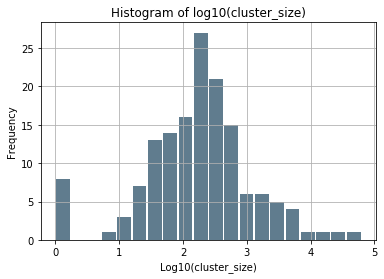

In [89]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(np.log10(df[:,1]))
commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of log10(cluster_size)')
plt.xlabel('Log10(cluster_size)')
#plt.grid(axis='y', alpha=0.75)

Text(0.5, 0, 'cluster_size')

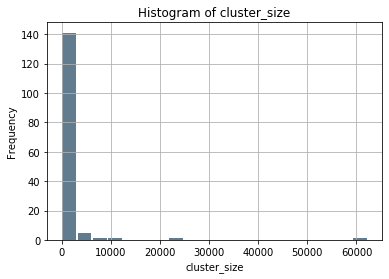

In [90]:
commutes = pd.Series(df[:,1])
commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of cluster_size')
plt.xlabel('cluster_size')

In [150]:
import pickle
filename="kmeans_1_7_wcount_division"

pickle.dump(kmeans, open(filename, 'wb'))

#kmeans = pickle.load(open(filename, 'rb'))

In [160]:
kmeans.labels_.shape

(357321,)

In [161]:
nn=len("/f92/f9255a80b42a51f8f04540f8c83c2ad414f79143")
print(nn)
print(filenames[0][-nn:])
#Data set based on base64s

sel_labels0=[kmeans.labels_[i_f[0]] for i_f in enumerate(filenames) if i_f[1][-nn:] in set([
"/f92/f9255a80b42a51f8f04540f8c83c2ad414f79143",
"/d75/d75da05450eae95bfe2951f8015bc10bc7576331",
"/ea6/ea642e784385a3f88213a99af62993b3bc6dbf3b",
"/e65/e657fc14f96ee9692df9931592d343e5dee8e0f7",
"/f73/f73b1bd66f0525137be779bc8ce46a562d33d283",
"/c12/c12168168d6ae301e1a77536c5afa1d1ddc0f68a",
"/e92/e922013d5d2d248312f944aea19ebc314823e8f1",
"/d7e/d7ed0aea9496c17c42df2e8e052dbd7c5c76631f",
"/d1a/d1ab228a31a206c554f77462103cd4b0ddf8ccb6",
"/c51/c51b07499035ddf58ceb3f481bd0d67d016e4c20",])]

45
/d7c/d7cb7d1263e3b53610e4a7ecc1890fc5bb62dd53


In [162]:
#Data set based on bip_boops

sel_labels1=[kmeans.labels_[i_f[0]] for i_f in enumerate(filenames) if i_f[1][-nn:] in set([
"/d37/d37bba3dd4b6e1d460b637bffd4bbad2c8c40e92",
"/eea/eeaa11d783c54a8adb8e4ffaee9826f46e0e3cfa",
"/de6/de665034de54a0048bd55a971dbc6e2c0a4bf151",
"/f36/f36738dc4368801622e50e1de2dc017a2e28dfa1",
"/c4e/c4e771565d8facf7fd3b7cd8f3f2eb2ae57bd574",
"/c51/c512594d43622383368b9fb924519899903253ce",
"/ef8/ef8a46653c1aef322f5231feac086289c317b6f2",
"/eb8/eb845fb2f8152d8f1f8f7bfa003eb3115dd9b03e",
"/c42/c42e2bc940685b5f7b5d072a71d5b1d64a3bad7f",
"/c31/c31dd900aa9924c3970fc232e072e49538f80cab"])]

In [163]:
#Data set based on songbooks

sel_labels2=[kmeans.labels_[i_f[0]] for i_f in enumerate(filenames) if i_f[1][-nn:] in set([
"/c44/c446d42ebcfb305b9a63d960839cb5f984f78254",
"/d9d/d9d9763b7b784e39c4d1fbd671cc6489ec2b3748",
"/d68/d680a3dbe858788bfea94a5779326d481ee9b912",
"/c44/c446d42ebcfb305b9a63d960839cb5f984f78254",
"/c0d/c0dc2ec8b91678506d54272505792681baa7328c",
"/e6c/e6c011bcc3be98867c667c47b9f98ef87b2128a5",
"/e7a/e7a7a1efe37719beaa9f5aa255426bf6e17f2903",
"/dd3/dd320441a659047551abee894668333bb410d675",
"/fdd/fdd1297ec579ae8169e99d478651e8e61912dc01",
"/dab/dab6d63bcd95380e65d977c7511cc2f5ee79b804",])]

In [164]:
#Data set based on words

sel_labels3=[kmeans.labels_[i_f[0]] for i_f in enumerate(filenames) if i_f[1][-nn:] in set([
"/d99/d9939a87d096b7cb089f4a1c2f4b609edf9a9c45",
"/dc6/dc6e3bb6b959a005c7897fd272d58134d2e9350e",
"/db0/db0e6eb250d4a9e28b5b16e3faad9c775dbe09b0",
"/ec8/ec889bc04771ba5192868a86360735b4fb923d94",
"/d21/d21c00ba4d78a71f4a7785b258fddb769b6c47f6",
"/c20/c20d24f75f444f03dde06fe0d3b9aeff48732552",
"/e8c/e8cb38536aefe09fbf22c82d8c9948d1424694ae",
"/d1a/d1aa38945e7cf0fa6d3991c091df2e7114632ba6",
"/f21/f21dbea3ba573c8000897a843505b9070f20bd2d",
"/cd6/cd673e091f613df8861efffd527588c0de11234f",])]

In [135]:
filenames[1:10]

['/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00bb05e027c1d918a30add58a3bd4665afcded85',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00b5ad7949fc5b0162826693a487e44f28a25ce5',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00bb5aa6abe04fb34c5f09e76086b3be1ffa21b8',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00bbfc80766fa2b0643ba40c9a9f74c7469d270a',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00b1ba1dd4c7368b2968685134003258471f980b',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00b66add2223b4b0b1b70213a389245a3f4cc8ee',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00bf8ecedd0f82ffb5a92235bb7583157c4d2839',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_data_80/00b/00b0b5734d1a6dec014f253ef517bc7e7404a2ed',
 '/mnt/servx1vol/Bams/genXone/20190914_1350_hackyeah/hackyeah_da

In [169]:
unique()

NameError: name 'unique' is not defined

In [204]:
import sys
import itertools as it
import time

print(sel_labels0)
for lb in set(sel_labels0):
    if lb==74: continue ## This cluster is too large, this is to be improved
    fset=set(np.asarray(filenames)[np.where(kmeans.labels_==lb)[0].tolist()])
    #[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
    for f in it.islice(fset,1000):
        sys.stdout.write("\n\n------------------  "+f[-61:]+"  --------------------\n")
        tenlines=open(f).readlines()[1:20]
        [sys.stdout.write(l) for l in tenlines]
        time.sleep(0.001)

[57, 57, 74]


------------------  hackyeah_data_80/de1/de1e974271e0dc72d755f6e9f8430f02ba764e07  --------------------
AEAAHAAbAAYAAAAEAAAAQAAAAAAAAABAAAAAAAAAAEAAAAAAAAAA+AEAAAAAAAD4AQAAAAAAAAgA
AAAAAAAAAwAAAAQAAAA4AgAAAAAAADgCAAAAAAAAOAIAAAAAAAAcAAAAAAAAABwAAAAAAAAAAQAA
AAAAAAABAAAABQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAqAAAAAAAAECoAAAAAAAAAACAA
AAAAAAEAAAAGAAAA2C0AAAAAAADYLSAAAAAAANgtIAAAAAAASAMAAAAAAACQAwAAAAAAAAAAIAAA
AAAAAgAAAAYAAADoLQAAAAAAAOgtIAAAAAAA6C0gAAAAAADwAQAAAAAAAPABAAAAAAAACAAAAAAA
AAAEAAAABAAAAFQCAAAAAAAAVAIAAAAAAABUAgAAAAAAAEQAAAAAAAAARAAAAAAAAAAEAAAAAAAA
AFDldGQEAAAA+CUAAAAAAAD4JQAAAAAAAPglAAAAAAAAhAAAAAAAAACEAAAAAAAAAAQAAAAAAAAA
UeV0ZAYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAABS
5XRkBAAAANgtAAAAAAAA2C0gAAAAAADYLSAAAAAAACgCAAAAAAAAKAIAAAAAAAABAAAAAAAAAC9s
aWI2NC9sZC1saW51eC14ODYtNjQuc28uMgAEAAAAEAAAAAEAAABHTlUAAAAAAAMAAAACAAAAAAAA
AAQAAAAUAAAAAwAAAEdOVQAlUDHqZcbGfqA7gdjit8tfA2x5fwMAAAAkAAAAAQAAAAYAAACIwSAB
AAVQCyQAAAAnAAAAKgAAACgdjBxCRdXsu+

AEAAHQAcAAYAAAAEAAAAQAAAAAAAAABAAAAAAAAAAEAAAAAAAAAAaAIAAAAAAABoAgAAAAAAAAgA
AAAAAAAAAwAAAAQAAACoAgAAAAAAAKgCAAAAAAAAqAIAAAAAAAAcAAAAAAAAABwAAAAAAAAAAQAA
AAAAAAABAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaAAAAAAAAABoAAAAAAAAAEAAA
AAAAAAEAAAAFAAAAACAAAAAAAAAAIAAAAAAAAAAgAAAAAAAA7RQAAAAAAADtFAAAAAAAAAAQAAAA
AAAAAQAAAAQAAAAAQAAAAAAAAABAAAAAAAAAAEAAAAAAAAD4BgAAAAAAAPgGAAAAAAAAABAAAAAA
AAABAAAABgAAAJhNAAAAAAAAmF0AAAAAAACYXQAAAAAAAIAEAAAAAAAAiAQAAAAAAAAAEAAAAAAA
AAIAAAAGAAAAsE0AAAAAAACwXQAAAAAAALBdAAAAAAAAIAIAAAAAAAAgAgAAAAAAAAgAAAAAAAAA
BAAAAAQAAADEAgAAAAAAAMQCAAAAAAAAxAIAAAAAAABEAAAAAAAAAEQAAAAAAAAABAAAAAAAAABQ
5XRkBAAAAHxEAAAAAAAAfEQAAAAAAAB8RAAAAAAAAFwAAAAAAAAAXAAAAAAAAAAEAAAAAAAAAFHl
dGQGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAUuV0
ZAQAAACYTQAAAAAAAJhdAAAAAAAAmF0AAAAAAABoAgAAAAAAAGgCAAAAAAAAAQAAAAAAAAAvbGli
NjQvbGQtbGludXgteDg2LTY0LnNvLjIABAAAABAAAAABAAAAR05VAAAAAAADAAAAAgAAAAAAAAAE
AAAAFAAAAAMAAABHTlUAPoq2pYFkd6UVrM4xDgJl4aXp2VcDAAAAQwAAAAIAAAAHAAAAsBCAAAIh

In [203]:
import sys
import itertools as it
import time

print(sel_labels1)
for lb in set(sel_labels1):
    #if lb==74: continue ## This cluster is too large, this is to be improved
    fset=set(np.asarray(filenames)[np.where(kmeans.labels_==lb)[0].tolist()])
    #[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
    for f in it.islice(fset,1000):
        sys.stdout.write("\n\n------------------  "+f[-61:]+"  --------------------\n")
        tenlines=open(f).readlines()[1:20]
        [sys.stdout.write(l) for l in tenlines]
        time.sleep(0.001)

[16, 50, 7, 138, 116, 48]


------------------  hackyeah_data_80/d74/d74fc555a5506265b0df9cee9add528d99a1d787  --------------------
Bop bop? bop booop-bop boooop bop biiiiiiip booop-bop bip! bip bop bip-bip
Bip bip! biiiiiiip bop biip bop? bop? boop! bop boop! bip bop bip! boooop bip? bip! bop booop-bop bip! boooop bip bop! bip bip biiiiiiip bop biip biip bip? bip bip? biip bop! bop? bop! biiiiiiip bip! bop! bop bop? bop bop bop? bip! bip-bip booop-bop biiiiiiip boooop bip
Bop booop-bop bip bip bip-bip bip! bip-bip bip bip biiiiiiip bip! bop? booop-bop bip? booop-bop bop? boooop biiiiiiip boop! bip! bop bip-bip bop? bop biiiiiiip bip biiiiiiip bop! bip bop bop? boop! booop-bop bip? booop-bop boooop
Bip-bip bip! bop? booop-bop bop bop? bip-bip biip bip bop bop bip bop! biiiiiiip biiiiiiip bip-bip bip biiiiiiip
Bip bop? bip! bip bip! bip? bop? bip bop bop! bop? bop biip bip-bip boooop booop-bop bip? bip booop-bop bip boooop bip-bip bop bip-bip bop! bip! biiiiiiip bip booop-bop bop booop-

Bip bop? bop! bip bop bop! bop! bip bop bop! biiiiiiip bop
Bop bop! biiiiiiip bip-bip bip bip? booop-bop boooop bip bip-bip biip bip? bip! boop! biiiiiiip bip! booop-bop bip? bop! bip boop! bop boooop boop! biip bip boop! bip! booop-bop bop
Bop? bop! bip? bip bop boooop bip! bip-bip bip? booop-bop bip-bip boop! boop! bip? bip? biiiiiiip bip? booop-bop bop! bip biip bip? bop bip? bop bip? bip-bip boop! biip bop? bop biip biiiiiiip bip-bip bop biiiiiiip boooop bop! booop-bop boooop bop! boop! bip? bop bop?
Boop! bip! biip biiiiiiip bip! bip-bip bop biiiiiiip bip-bip bop bip bip biiiiiiip bip-bip bop bip bip! bip boooop bip! bip boop! bip? biip bip? bop bop bop bip bop?
Bip bip boop! booop-bop bip bip? bop bop?
Bop! bip? boooop boop! bop? bop biiiiiiip booop-bop biip bip! biip biip boop! biip bip! bip! bip bip bip bop? bip bip! bip bip bip-bip bip? boooop boooop bip? biip bop bip-bip booop-bop boooop
Bip? bip bop? bop? bip! bip bop boooop bop boop! biiiiiiip bip bip? bop? booop-bop bip bo

Bip! bip booop-bop bop boop! bop? bop? bop bop bip! booop-bop boop! boooop bop bip boop! bop booop-bop bip! biip bop? bip biip
Boop! bip biiiiiiip bop! biiiiiiip boooop bop? bop bop! bip-bip bop bip! boooop boooop bop? bip
Biiiiiiip bop bip biiiiiiip biiiiiiip bop? bop bop bip bip? bip? bop? biip bip? booop-bop boop! bop? booop-bop bip!
Bop! bop bip! bop! bip bip! bip? boop! bip bop bip boooop bop! boooop biiiiiiip bip? boop! bop bip! bip? bop boop! bop bip bop!
Bip bip? bip bip bip! bop! bip-bip bip-bip boooop bip! bop bop! bop bop? bip? bip-bip boop! bip! bip bip? bip? bop bip bop? booop-bop bip! boop! bop? bip booop-bop bop? booop-bop bop bop bop bip booop-bop bip-bip bip bop! bip-bip bip bip? bip biiiiiiip bip-bip
Bip! biiiiiiip bop biiiiiiip bop! bip? biiiiiiip bop? booop-bop boooop bip! bop bop bip bip! bip! bip bip bip-bip bop? bip! boooop bip bop? bip! bip! bip-bip biiiiiiip bip? bip! bip-bip bop boop! bop! bip? bop! bop biiiiiiip boooop
Bop! biiiiiiip bop? biip bop biip boop! 



------------------  hackyeah_data_80/d74/d7462f00891a12f3b3b4df312ad19ac1b3e550eb  --------------------
Bop? boop! bip bop! bip bop? bop biiiiiiip bip-bip bop bop! bop! bip bip-bip boooop bop! bop bip bop! biiiiiiip bip-bip bop biip bip? bop! biip bop biip bop! boooop bop! bip? bip-bip bop biip boooop
Biiiiiiip biip bip-bip bip! boop! boooop boop! biip boooop bop! bop boooop bip? bip bip bop? booop-bop booop-bop bop! biip bip-bip bop bop! bop bop? bip bop? bip bop bip! boop! bip! biip bip boooop bip
Boooop bip bip-bip bip! bip? bip? biip bop booop-bop boop! boooop boooop boop! bip! bip! bip-bip bop bop? bop bip! bop bop! boop! bip-bip bip bop! bip! boop! biip boop! booop-bop booop-bop bip! bip bip? bop booop-bop bop! biip biip boooop biip bip bop! boop! biip bip? booop-bop
Bop bip? bop bop bop? boooop bop! bip! booop-bop bip biiiiiiip bop! bip-bip bip! bop bip biiiiiiip boooop biiiiiiip bip-bip bop bop! bip biip bop! bip booop-bop biiiiiiip bop
Bip! biip bop? bip bop boop! bop? biiii



------------------  hackyeah_data_80/d2f/d2fb966445514f96ca79dcf5014b16f8d3dda999  --------------------
Biip bip bip! biip bip-bip bop bop boop! biiiiiiip bop? bop? bop! boooop bip! bop!
Bop? boop! bip booop-bop bip-bip bop boooop bip biiiiiiip bop! bip biip bop! biip bip! bop! boooop boooop bop? bip? bop?
Booop-bop bop! bop bop! bop bip! bip bip! boop! biip bop? boop! bop
Bop? biiiiiiip boooop bop? bip? bop boop! boooop booop-bop bop bip boooop bip bip bip-bip booop-bop bip! bip-bip bip! biiiiiiip bip bip bip biiiiiiip boooop bip bop bop bip! bop? bip bip-bip booop-bop bop bip-bip bip bop! bip-bip biip bip bop?
Bip-bip biiiiiiip biiiiiiip bip bop! bip boop! biiiiiiip bop bop! bip bop boooop bop bip-bip boooop bip? biip bip biip bip? bip? biiiiiiip biiiiiiip bop bip bip! bip bop? bip! bop bop? bip? biip bip bip! bop booop-bop bip bop? bop! boop!
Boooop bip booop-bop bip bop bip-bip bip bip boooop bip? boooop bip-bip biip boop! bop biip bop bop bip bop? bop bop! booop-bop bip-bip bop 



------------------  hackyeah_data_80/c84/c8494c2be99836e926e0fbc5198ec321a899c845  --------------------
Biip bop booop-bop bip-bip bop? bip! bip biip bop! bop? bip biiiiiiip bip bop! boop! bip bip! bop biip boop! boooop bip bip bop! bip? biip boop! bip? bip! biip bop! biiiiiiip
Bop! bip? bop bop? bip? bip! bip-bip booop-bop bip! biip boooop boop! bop!
Bip-bip bip boooop booop-bop bop bip biip biip bop! boooop bop! boop! bop! bop? boop! booop-bop biip bip bip biiiiiiip bop biiiiiiip biiiiiiip bop bip booop-bop bop! biip bop? bip! boooop boop! bip! biiiiiiip bip? boooop biiiiiiip
Bop biiiiiiip boooop biiiiiiip booop-bop bop! boop! bip! boooop biip booop-bop bip boop! boooop bip? biiiiiiip biip bip! bop bip! bop? bip bop! biip bip-bip boooop
Bop! bip bip! boooop bip bop! booop-bop bop! booop-bop bop? biiiiiiip bip biiiiiiip bop booop-bop biiiiiiip bop biiiiiiip bop bip? booop-bop bop! boop! bop? bop bip! bip-bip bip biiiiiiip bop bip-bip biip biiiiiiip bip bop booop-bop bip? bip-bip bip



------------------  hackyeah_data_80/cb3/cb35a97eda0c53bd84beab9400edf649b81f27a4  --------------------
Bop? bop! boop! bop? boop! boop! bop booop-bop bip-bip booop-bop bop! bip bip-bip biip bip booop-bop boop! bip? bip! bip! bip bop biiiiiiip biip bip bip boop! booop-bop bop? booop-bop boop! biip bop! boooop bip bip-bip bip bip boop! booop-bop booop-bop biip bop? booop-bop bip! bip-bip boop! bop! boop!
Bip boop! boop! boop! bop biip bip bip bop? bop bop boooop bip? biip bop? bop! boop! biip bop! booop-bop bip bop boop! bip biip bop! boop! bop boop! booop-bop
Bop! bop? bop! boop! bip bop bop booop-bop biip bip biiiiiiip booop-bop bip bip bip! biip bop biiiiiiip
Biip bop bop? boop! bip-bip bip biip booop-bop bip bip? bip biip bop boooop booop-bop biip bip bip! boooop biip boooop bop! boooop biip biiiiiiip bop booop-bop
Bop bip? boooop bip bop bip-bip bip? boop! bip bop? biip bop? bip? bip! bip bip! booop-bop bop! boop! bip boop! biiiiiiip biiiiiiip bip bip biip bop bop! bop? boooop bo

In [205]:
import sys
import itertools as it
import time

print(sel_labels2)
for lb in set(sel_labels2):
    if lb==74: continue ## This cluster is too large, this is to be improved
    fset=set(np.asarray(filenames)[np.where(kmeans.labels_==lb)[0].tolist()])
    #[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
    for f in it.islice(fset,1000):
        sys.stdout.write("\n\n------------------  "+f[-61:]+"  --------------------\n")
        tenlines=open(f).readlines()[1:200]
        [sys.stdout.write(l) for l in tenlines]
        time.sleep(0.001)

[131, 131, 74, 74, 131, 131]


------------------  hackyeah_data_80/c6a/c6a83cdd0df31a1d31b2b713e032fc35c9fa5154  --------------------
devanger
czemu ja na ts nie moge do nikogo pisac
doslownie do nikogo
DevangerDziś o 10:33
Możesz pisać tylko do osób, którzy maja rangę kanałową u ciebie. Jest to zrobione przez to, że sporo osób reklamowało się.
3W3L1N4Dziś o 10:33
aha
ale jak reektu se zdejmie wlasciciel MC to nie moge do niego pisac XD
DevangerDziś o 10:34
do administracji możesz pisać.
3W3L1N4Dziś o 10:34
ale krzychowsky ma helper mc i do niego tez pisac nie moglem
nie moge
wlasnie
do nikogo
DevangerDziś o 10:35
wszystko możesz.
3W3L1N4Dziś o 10:35
no nie moge XD
DevangerDziś o 10:35
To debilem jesteś proste.
3W3L1N4Dziś o 10:35
mowisz, ze moge do administracji pisac?
DevangerDziś o 10:35
Tak.
3W3L1N4Dziś o 10:36
https://scr.hu/VgBLlJ3
to co mi teraz powiesz?
DevangerDziś o 10:36
Jak mają anty pw/poke to nie moja wina.
3W3L1N4Dziś o 10:36
on nie ma
DevangerDziś o 10:36
Możesz przeci


Imię: Dominik

Wiek: 18

Znajomość RP(0-10):11

Umiejętnośc pracy w grupie(0-10):10

Poziom twojej kultury(0-10):10

Nick na Discordzie: : VeeQ#7484

Czy posiadasz sprawny mikrofon?: tak

Ile czasu w ciągu dnia spędzasz na grę?: praktycznie caly dzien

Coś o sobie (minimum 3 pełne zdania): no to tak, Nazywam się Dominik, mam 18 lat. interesuje się medycyną i napewno poradził bym sobie w roli EMS. Jestem aktywnym graczem nie tylko rp ale też innych gier, myśle że bardzo pomogl bym w rozwinięciu się serwera 

Dlaczego wybrałeś Policje?: (chyba chodzi czemu wybralem EMS xd) Lubie pomagać innym obywatelom miasta, lecz jako zwykła osoba nie wiele moge zdziałać. A ludzie w tym miescie non stop potrzbują pomocy. I ja jestem gotowy, aby im pomoc

Wyjaśnij pojęcia:

Akcja RP- odgrywanie prawdziwego Zycia

Fail RP- Odgrywanie czegoś co nie moglo sie wydarzyc w realnym zyciu

VDM- jest to najeżdżanie na osobę, w celu wbicia jej BW

CK- jest to nic innego jak permanentne uśmiercenie swojej postac

 
1) Quels sont les rôles de Modération disponibles sur ExploreMC ? 
2) Qui/Quels est/sont le/les responsable(s) Staff ?
3) Qui est/qui sont le/les administrateur(s) d'ExploreMC ? 
4) Quelles sont vos motivations pour rejoindre l'équipe ExploreMC 
5) Quels sont les mini-jeux disponibles sur ExploreMC ?
6) Quel est le rang de départ lorsque l'on entre dans l'équipe du Staff d'ExploreMC ?
7) Que pensez-vous de la baisse de joueurs sur Minecraft ?
8) Parlez-nous de votre point de vue sur l'avenir d'ExploreMC ?
 
--------------------------------
Mise en situation - ExploreMC
 
1) Un joueur vous insulte sur le chat discord, que faites-vous ? 
 
2) Un joueur vous insulte sur nos plateformes TeamSpeak, que faites vous ? 
 
 
3) Un joueur dis : "fd p" dans le chat, que faites vous ?
 
 
4) Un joueur dis "fdp" dans le chat, que faites vous ? 
 
5) Un joueur dis "ta connexion va vite tomber" que faites vous ? 
 
6) Un joueur dis "PLAY.FUNCRAFT.FR, venez vite ! CRACK [ON]" que faites vous ?
 
---

#NPCKI EXP 75
    npc1-exp75-kolornicku: &2
    npc2-exp75-kolornicku: &2
    npc3-exp75-kolornicku: &2
 
    npc1-exp75: Valla
    npc2-exp75: Zszywaniec
    npc3-exp75: Ilidan

# (QUEST 0)
    npc1-exp75-questnazwa: &6Eksperyment
    npc1-exp75-quest0: ||&aWitaj! Przygotowywalismy razem z mieszkancami||&aPewien eksperyment. ||&aChcielismy stworzyc monstra ktore zatrzymaje te ataki||&aNiestety cos nie wyszlo… ||&aPomoz nam zabic te krowy!!! ||&aZebysmy mogli skupic sie na wrogu! ||||b&lCel: ||&eZabij &2200x Zmutowane Bydlo || ||&aKliknij na ikone gdy ukonczysz zadanie!
    npc1-exp75-quest1: &6Te wszystkie krolestwa sa atakowane a my bawimy sie z krowami!
    npc1-exp75-quest2: &6Moze by tak sprobowac czegos innego?
    npc1-exp75-quest3: &6Nigdy nie wygraja! Nasze sily sa dla nich zbyt potezne.

    npc1-exp75-podziekowania: &6Wreszcie, to bydlo tylko przeszkadzalo!
    npc1-exp75-nieukonczone: &6Szybko! Zanim te bydla sie rozmnoza! Starczy nam jedna mutacja!
  
# (QUEST 1)
    npc2-



------------------  hackyeah_data_80/c41/c41c944d7c0862ee49f8bf1b83b727ec061d2269  --------------------
Saint-George se tient fièrement sur son cheval blanc, une armure étincelante sur le corps et un cimeterre meurtrier à la main droite. On reconnait aisément l'image du chevalier courageux et sans reproche qui se bat pour protéger la princesse. Sa lance bien que cassé et à terre, est tout de même enfoncée dans le poitrail du dragon qui se tord de douleur. Cette image du chevalier renvoi aux œuvres du Moyen-Age. Au pied du cheval se trouve le dragon qui se tord de douleur, et semble prêt à se rendre. L’arrière-plan est divisé en deux par saint-George, à gauche se trouve l'horizon les arbres et d'autres collines; à droite se trouve la princesse apeuré qui tente de se réfugier derrière les collines.
4) Saint-George est mit en valeur, et représente a la fois le chevalier preux du Moyen-Age et le Saint modèle à suivre. Ainsi Saint-George serait George de Lydda, martyre chrétien dont l'exi

/*!40101 SET COLLATION_CONNECTION=@OLD_COLLATION_CONNECTION */;

------------------  hackyeah_data_80/c89/c89049e84c365cb3bc34baa49cf6ad6443c61e3f  --------------------
Ivysaur
Venusaur
Charmander
Charmeleon
Charizard
Squirtle
Wartortle
Blastoise
Caterpie
Metapod
Butterfree
Weedle
Kakuna
Beedrill
Pidgey
Pidgeotto
Pidgeot
Rattata
Raticate
Spearow
Fearow
Ekans
Arbok
Pikachu
Raichu
Sandshrew
Sandslash
Nidoran♀
Nidorina
Nidoqueen
Nidoran♂
Nidorino
Nidoking
Clefairy
Clefable
Vulpix
Ninetales
Jigglypuff
Wigglytuff
Zubat
Golbat
Oddish
Gloom
Vileplume
Paras
Parasect
Venonat
Venomoth
Diglett
Dugtrio
Meowth
Persian
Psyduck
Golduck
Mankey
Primeape
Growlithe
Arcanine
Poliwag
Poliwhirl
Poliwrath
Abra
Kadabra
Alakazam
Machop
Machoke
Machamp
Bellsprout
Weepinbell
Victreebel
Tentacool
Tentacruel
Geodude
Graveler
Golem
Ponyta
Rapidash
Slowpoke
Slowbro
Magnemite
Magneton
Farfetch’d
Doduo
Dodrio
Seel
Dewgong
Grimer
Muk
Shellder
Cloyster
Gastly
Haunter
Gengar
Onix
Drowzee
Hypno
Krabby
Kingler
Voltorb
Elec

             

------------------  hackyeah_data_80/ca3/ca3d8f0b2a21579cac3875d0ba5034917db8f6be  --------------------
Onion sozdajut łjudi s obostrjennym czuwstwom sprawjedłiwosti, dłja kotorych anonimnost, bjezopasnost i swoboda imjejut wysszij prioritjet srjedi ostałnych aspjektow obszczjenija. I zdjes swoi prawiła.
My nje chotim promjenjat swoi swobody na zołotyje kłjetki. My chotim sami rjeszat, kak i czjem objezopasit sjebja i swoich błizkich, kak organizowywat dosug, kak wospitywat sobstwjennych djetjej. My sami chotim kontrołirowat to, czto popadajet w nasz organizm. My - za swobodu słowa, mnjenij i obmjena informacii. My - za bjezopasnost swojej łicznoj żizni, tajnu pjerjepiski i za połnyj kontroł nad tjemi, komu po njedorazumjeniju popała w ruki włast prinimat rjeszjenija za nas.
Onion sozdan dłja obszczjenija łjudjej, sogłasnych s dannym Manifjestom. Zdjes nje tjerpjat prowokacii, głupost i łicjemjerije. Intjerjesnym łjudjam so swoim sobstwjennym mnjenijem zdjes wsjegda rady

smiech i smutek sie przeplata, oba po równi na szalach
równowaga jak wskazuje waga [Bradah!] to Twoja wlasna Saga
Chronos lubi figle platac, moge mówic na przykladach
Rzecz do tego sie sprowadza : Starzec patrzy na dzieciaka 
jak po podwórku hasa, pala zazdroscia, wspomina mlososci lata
chce mu sie plakac,bo wzial je z obojetnoscia
jak laska partnera w porno, łamie go w gnatach ot co
dzis u niego kiepsko z forma, winne jest bongo
w plucach osad daje sie we znaki mocno
chcialby czas cofnac a tu nie wolno

Dzis wlosy juz siwe, barwy jak nikiel, dupsko otyle, wlecze sie w tyle
zeby ze zdartym szkliwem, krusza sie gdy gryzie
w dodatku jest krótkowidzem, przypomina inwalide
bo ledwo idzie, a z trudem siada na kibel
i choc nie jest Alladynem, mysli "Dzinie, chce byc znów mlody na chwile"
"Wyrwac dziewczyne, pograc w pile"
"hm jak widze, sam sobie jestes winien Synek, tyle"

Chcemy żyć jak na Bahamach, bujać się jak Hamak
świat ten badać i poznawać, wciąż doznawać w codzienności ramach
ale pa

 
Sehr gute Kamera für sehr kleinen Preis - Preisleistungsverhältnis ist Top!
 
Ich habe diese Kamera am 25.06.2018 bestellt, am 26.06.2018 kam sie dann an. Ich vergebe hier für verschiedene Kategorien Sterne.

Verpackung:
Siehe Abbildungen. Generell schön verpackt – Verpackung aus Pappe, dennoch hochwertig wirkend. Keine negativen auffallenden Punkte. ->
5/5 Sterne

Packungsinhalt:
Siehe Abbildungen.
-Kamera selbst
- Adapter zum Aufladen mit zwei verschiedenen Steckdosen-Aufsätzen
- ziemlich langes micro-usb-Kabel
-Montage-Set
-Bedienungsanleitung
Auch hierbei fällt auf, dass der Packungsinhalt sortiert und nicht lieblos reingeschmissen wurde. Generell ordentlich und mit Ordnung verpackt.
5/5 Sterne

Bedienungsanleitung:
- 6 Sprachen
- Deutsche Sprache wird mehr oder wenig sachgemäß verwendet -> keine fatalen grammatikalischen Fehler (wobei es ab und zu Unklarheiten gibt)
- Gute Rechtschreibung
-Allgemein sehr verständlich erklärt
4/5 Sterne

App
- kostenlose APP für Android und iOS
-

In [206]:
import sys
import itertools as it
import time

print(sel_labels3)
for lb in set(sel_labels3):
    #if lb==74: continue ## This cluster is too large, this is to be improved
    fset=set(np.asarray(filenames)[np.where(kmeans.labels_==lb)[0].tolist()])
    #[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
    for f in it.islice(fset,100):
        sys.stdout.write("\n\n------------------  "+f[-61:]+"  --------------------\n")
        tenlines=open(f).readlines()[1:200]
        [sys.stdout.write(l) for l in tenlines]
        time.sleep(0.001)

[74, 74, 74]


------------------  hackyeah_data_80/db4/db485c7ad3638a2fb6b85e09be7745e2672d120e  --------------------
<000>clr_chams_ct_vis 0 21 255 185
<000>clr_chams_ghost_client 255 255 255 255
<000>clr_chams_ghost_server 50 50 50 255
<000>clr_chams_hands_primary 255 0 0 255
<000>clr_chams_hands_secondary 0 0 255 255
<000>clr_chams_historyticks 255 255 255 255
<000>clr_chams_other_invis 255 255 255 255
<000>clr_chams_other_vis 178 178 178 255
<000>clr_chams_t_invis 63 255 0 120
<000>clr_chams_t_vis 45 255 0 108
<000>clr_chams_weapon_primary 0 3 255 255
<000>clr_chams_weapon_secondary 0 9 255 255
<000>clr_esp_bar_ammo1 4 104 240 255
<000>clr_esp_bar_ammo2 4 104 240 255
<000>clr_esp_bar_armor1 200 200 200 255
<000>clr_esp_bar_armor2 100 100 100 255
<000>clr_esp_bar_health1 0 255 0 255
<000>clr_esp_bar_health2 255 0 0 255
<000>clr_esp_box_ct_invis 255 255 255 255
<000>clr_esp_box_ct_vis 255 255 255 255
<000>clr_esp_box_other_invis 255 255 255 255
<000>clr_esp_box_other_vis 178 178 178

.tsf{
    margin: 0 auto;
}

/* search tool bar */
#hdtb-msb,
#resultStats {
    position: relative;
    left: calc((100vw - 950px)/2);
}

/* bottom info bar */
.B4GxFc {
    margin-left: calc((100vw - 950px)/2);
}

------------------  hackyeah_data_80/c1e/c1e45da712d03aaca208cd0ff83e8d76b6c7eebd  --------------------

********************
Compromise And Discovery Download
http://urllio.com/r0l3w
(Copy & Paste link)
********************





































  a5c7b9f00b

------------------  hackyeah_data_80/c5f/c5fcdb66479c4b472d89138b9414dcfb55f0c945  --------------------
  transition: transform 500ms ease;
}

------------------  hackyeah_data_80/dd7/dd7f6e65c6b12a0d11bb0911a838354049cc036e  --------------------
MacBook-Pro-de-Helder-Sousa:SiriProxy sousa$ sudo gem install /Users/sousa/SiriProxy/pkg/siriproxy-0.3.0.gemERROR:  Error installing /Users/sousa/SiriProxy/pkg/siriproxy-0.3.0.gem:
    siriproxy requires Ruby version >= 1.9.2.
MacBook-Pro-de-Helder-Sousa:SiriPr

In [ ]:
########

In [218]:
import sys
import itertools as it
import time


lab=10
print([lab,list(counts[np.where(labels==lab)])])

for lb in set([lab]):
    #if lb==74: continue ## This cluster is too large, this is to be improved
    fset=set(np.asarray(filenames)[np.where(kmeans.labels_==lb)[0].tolist()])
    #[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
    for f in it.islice(fset,100):
        sys.stdout.write("\n\n------------------  "+f[-61:]+"  --------------------\n")
        tenlines=open(f).readlines()[1:200]
        [sys.stdout.write(l) for l in tenlines]
        time.sleep(0.001)

[10, [429]]


------------------  hackyeah_data_80/dc4/dc44ae9a60c612c91d3ca6aafe8f996d21b87296  --------------------
 
''We hold these truths to be self-evident: that all men are created equal; that they are endowed by their Creator with certain unalienable rights; that among these are life, liberty, and the pursuit of happiness.''
 
'''We are researchers who deal in open-source information, reasoned argument, and dank memes.  We do battle in the sphere of ideas and ideas only.  We neither need nor condone the use of force in our work here.'''
 
==VINCIT OMNIA VERITAS==
==SEMPER FIDELIS==
==WWG1WGA==
 
==Q Proofs & Welcome==
'''Welcome to Q Research (README FIRST, THEN PROCEED TO LURK)''' https://8ch.net/qresearch/welcome.html
'''Storm Is Upon Us - YT Channel''' - https://www.youtube.com/channel/UCDFe_yKnRf4XM7W_sWbcxtw
''Recommended viewing chronologically'', beginning with: '''Q - The Plan to Save the World''' - https://youtu.be/3vw9N96E-aQ
'''Q: The Basics - An Introduction to Q an

>>1121104 --------- Q Questions

------------------  hackyeah_data_80/da1/da1a87e0926900cd2b9d378d12579c34d2baeca0  --------------------
 
'''We hold these truths to be self-evident: that all men are created equal; that they are endowed by their Creator with certain unalienable rights; that among these are life, liberty, and the pursuit of happiness.'''
 
''Integrity--for in Truth lies Victory.''
 
'''Please Read Our Designated Disclaimer''' https://8ch.net/qresearch/welcome.html
 
==VINCIT OMNIA VERITAS==
==SEMPER FIDELIS==
'''www.QProofs.com'''
==WWG1WGA==
 
'''Welcome to Q Research (README FIRST, THEN LURK)''' https://8ch.net/qresearch/welcome.html
'''Our Best of the Best Q Proof Bread''' >>1552095 SEE FOR YOURSELF
'''Discussion and Refinement bread for our Best Q Proofs Sticky''' >>1739215
'''100+ Q Proof Graphics download''' qproofs.com
'''Q Plan to Save the World''' - Video introduction to the Q plan - https:''//''youtu.be/6cYZ8dUgPuU
 
=='''Q's Latest Posts'''==
'''Q's Private B

Book of Q Proofs -----

------------------  hackyeah_data_80/d1a/d1a2de0ec8b63d98a4c2faf14b95e94e203e7a5a  --------------------
Date: Tue, 27 Feb 1996 00:52:43 -0700
From: mvanalst@rbi.com (Mark Van Alstine)
Subject: Cremation capacities of Kremas I-V (March-December,1943)
Newsgroups: alt.revisionism

(A copy of this message has also been posted to the following newsgroups:
alt.revisionism)

Lately there has been much ado about the incineration capacities of the
Kremas, especially Kremas II-V at Auscwitch II-Birkenau. It has been the
contention of some Holocaust deniers that these Kremas were simply needed
to handle the number of "natural" deaths that happened at Auschwitz. One
number that has been tossed around is 70,000 people dying of "natural
causes" at Auschwitz. Another is 45,575 for the year 1942. At the height
of the typhus epidemic in July of 1942, the death toll was 4,000 per month
[1] Now, assuming for argument's sake, that the death toll from such
"natural causes" was const

In [221]:
import sys
import itertools as it
import time


lab=98
print([lab,list(counts[np.where(labels==lab)])])

for lb in set([lab]):
    #if lb==74: continue ## This cluster is too large, this is to be improved
    fset=set(np.asarray(filenames)[np.where(kmeans.labels_==lb)[0].tolist()])
    #[documents2_org[i_f[0]] for i_f in enumerate(filenames_org) if i_f[1] in fset]
    for f in it.islice(fset,100):
        sys.stdout.write("\n\n------------------  "+f[-61:]+"  --------------------\n")
        tenlines=open(f).readlines()[1:100]
        [sys.stdout.write(l) for l in tenlines]
        time.sleep(0.001)

[98, [225]]


------------------  hackyeah_data_80/cc8/cc8f4b6cbe5aea9824c83227c201f0eedc4a977e  --------------------
[00:30:29] [Client thread/INFO]: [CHAT] tps_last_5: 19.959003104422884
[00:30:29] [Client thread/INFO]: [CHAT] tps_last_15: 19.967011743038654
[00:30:29] [Client thread/INFO]: [CHAT] world_world_entities: 12
[00:30:29] [Client thread/INFO]: [CHAT] world_world_players: 0
[00:30:29] [Client thread/INFO]: [CHAT] world_world_loadedChunks: 256
[00:30:29] [Client thread/INFO]: [CHAT] world_world_the_end_entities: 9
[00:30:29] [Client thread/INFO]: [CHAT] world_world_the_end_players: 0
[00:30:29] [Client thread/INFO]: [CHAT] world_world_the_end_loadedChunks: 256
[00:30:29] [Client thread/INFO]: [CHAT] world_nether_entities: 31
[00:30:29] [Client thread/INFO]: [CHAT] world_nether_players: 2
[00:30:29] [Client thread/INFO]: [CHAT] world_nether_loadedChunks: 444
[00:30:29] [Client thread/INFO]: [CHAT] world_CaveWorlds_entities: 2172
[00:30:29] [Client thread/INFO]: [CHAT] world_C



------------------  hackyeah_data_80/d29/d29c73b1aebbc6fb09748a7d412318887c0a1532  --------------------
[01:34:42] [main/WARN]: Ambiguity between arguments [teleport, location] and [teleport, destination] with inputs: [0.1 -0.5 .9, 0 0 0]
[01:34:42] [main/WARN]: Ambiguity between arguments [teleport, location] and [teleport, targets] with inputs: [0.1 -0.5 .9, 0 0 0]
[01:34:42] [main/WARN]: Ambiguity between arguments [teleport, targets] and [teleport, destination] with inputs: [Player, 0123, dd12be42-52a9-4a91-a8a1-11c01849e498]
[01:34:42] [main/WARN]: Ambiguity between arguments [teleport, targets, location] and [teleport, targets, destination] with inputs: [0.1 -0.5 .9, 0 0 0]
[01:34:42] [main/INFO]: Loaded 0 recipes
[01:34:42] [Server thread/INFO]: Starting minecraft server version 1.13
[01:34:42] [Server thread/INFO]: Loading properties
[01:34:42] [Server thread/INFO]: Default game type: CREATIVE
[01:34:42] [Server thread/INFO]: This server is running CraftBukkit version git-Spi

In [47]:
#centers_descr=[]
#centers_descr.append((78,["code","javascript"]))


In [220]:
model.save("model_1_15_gensim")
#model = gensim.models.Word2Vec.load("model_1_15_gensim")

2019-09-15 04:29:06,101 : INFO : loading Word2Vec object from model_1_15_gensim
2019-09-15 04:29:15,855 : INFO : loading wv recursively from model_1_15_gensim.wv.* with mmap=None
2019-09-15 04:29:15,856 : INFO : loading vectors from model_1_15_gensim.wv.vectors.npy with mmap=None
2019-09-15 04:29:16,262 : INFO : setting ignored attribute vectors_norm to None
2019-09-15 04:29:16,263 : INFO : loading vocabulary recursively from model_1_15_gensim.vocabulary.* with mmap=None
2019-09-15 04:29:16,263 : INFO : loading trainables recursively from model_1_15_gensim.trainables.* with mmap=None
2019-09-15 04:29:16,264 : INFO : loading syn1neg from model_1_15_gensim.trainables.syn1neg.npy with mmap=None
2019-09-15 04:29:16,649 : INFO : setting ignored attribute cum_table to None
2019-09-15 04:29:16,649 : INFO : loaded model_1_15_gensim


In [217]:
import pickle
filename="kmeans_1_15_wo_count_division"

pickle.dump(kmeans, open(filename, 'wb'))

#kmeans = pickle.load(open(filename, 'rb'))

179241

### Similarity between two words in the vocabulary

You can even use the Word2Vec model to return the similarity between two words that are present in the vocabulary. 

Under the hood, the above three snippets computes the cosine similarity between the two specified words using word vectors of each. From the scores, it makes sense that `dirty` is highly similar to `smelly` but `dirty` is dissimilar to `clean`. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0]. You can read more about cosine similarity scoring [here](https://en.wikipedia.org/wiki/Cosine_similarity).

### Find the odd one out
You can even use Word2Vec to find odd items given a list of items.

## Understanding some of the parameters
To train the model earlier, we had to set some parameters. Now, let's try to understand what some of them mean. For reference, this is the command that we used to train the model.

```
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
```

### `size`
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me. 

### `window`
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window. 

### `min_count`
Minimium frequency count of words. The model would ignore words that do not statisfy the `min_count`. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

### `workers`
How many threads to use behind the scenes?


## When should you use Word2Vec?

There are many application scenarios for Word2Vec. Imagine if you need to build a sentiment lexicon. Training a Word2Vec model on large amounts of user reviews helps you achieve that. You have a lexicon for not just sentiment, but for most words in the vocabulary. 

Beyond, raw unstructured text data, you could also use Word2Vec for more structured data. For example, if you had tags for a million stackoverflow questions and answers, you could find tags that are related to a given tag and recommend the related ones for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. Granted, you still need a large number of examples to make it work. 
